In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **A. Import libraries**

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 68 kB/s 


In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import lightgbm as lgb
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Imbpipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

**Display settings**

In [ ]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)

# **B. Function**

In [ ]:
def reformat_column_name(data):
    """Rename columns in correct format.

    Args: 
        data: dataframe with incorrect column name.

    Return:
        dataframe with correct column name.
    """
    data.rename(
        columns={
            'forecasting period': 'forecasting_period', 
            'total_costs_overtotal_sales': 'total_costs_over_total_sales',

            'cash_plus_short_term_securities_plus_receivables_minus_short_term_liabilities_over_operating_expenses_minus_depreciation_times_365': 
            'cplus_sts_plus_r_minus_stl_over_oe_minus_d_times_365',

            'current_assets_minus_inventory_minus_short_term_liabilities_over_sales_minus_gross_profit_minus_depreciation':
            'ca_minus_i_minus_stl_over_sales_minus_gp_minus_d'
        }, 
        inplace=True
    )
    
    return data


def replace_question_mark_with_nan(data):
    """Replace '?' in dataframe with 'NaN.

    Args: 
        data: dataframe has '?'.

    Return:
        dataframe has '?' replaced by 'NaN'
    """
    data = data.replace('?', np.nan)
    return data


def check_null_values(data):
    """Check number and percentage of null values in each column.

    Args: 
        data: dataframe.

    Return:
        table containing column names, number, percentage of null values
    """
    null_data_df = data.isnull().sum().reset_index().sort_values(by=0) \
                       .rename(columns={'index':'column_name', 
                                        0:'number_of_null_values'})
    null_data_df['percentage'] = round(null_data_df.number_of_null_values 
                                       / data.shape[0] * 100, 3)
    null_data_df = null_data_df.sort_values(by='percentage', ascending=False)
    null_data_df.reset_index(drop=True, inplace=True)
    return null_data_df


def convert_data_type(data, have_class=True):
    """Convert data type of columns to correct format.

    Args: 
        data: dataframe
        have_class: whether the dataframe has a 'class' column, boolean.

    Return:
        dataframe has columns with correct data type.
    """
    if have_class==True: 
        data = data.astype('float', errors='ignore')
        columns = ['id', 'class', 'forecasting_period']
        data[columns] = data[columns].astype('category', errors='ignore')
    else:
        data = data.astype('float', errors='ignore')
        columns = ['id', 'forecasting_period']
        data[columns] = data[columns].astype('category', errors='ignore')    
    return data


def visualize_percentage_null_values(data):
    """Visualize bar graph of percentage of null values of columns.

    Args: 
        data: dataframe.

    Return:
        bar graph of percentage of null values of columns.
    """
    fig, ax = plt.subplots(figsize=(30, 6))
    sns.barplot(
        x='column_name',
        y='percentage',
        data=data,
        palette='Blues_r',
        ax=ax
    )
#     ax.axhline(y=5, color='red')
    ax.set_title('Percentage of null values in each column\n', fontsize=15)
    ax.set_xlabel('Column', fontsize=13)
    ax.set_ylabel('Percentage (%)', fontsize=13)
    ax.set_xticklabels(data.column_name, rotation=90)
    ax.set_yticks(np.arange(0, 55, 5))
    plt.close()
    return fig 


def visualize_boxplot(data, title_boxplot=''):
    """Visualize boxplot of columns.

    Args: 
        data: dataframe
        title_boxplot: tilte of boxplot.

    Return:
        boxplot of columns.
    """
    fig, ax = plt.subplots(figsize=(25, 6))
    ax = sns.boxplot(data=data.select_dtypes('float'), palette='Blues_r') 
    ax.set_title(
        'Boxplot ' + title_boxplot + ' (log scale)\n', 
        fontsize = 18
    )
    ax.set_yscale(value='log')
    ax.set_xticklabels(data.select_dtypes('float').columns, rotation=90)
    plt.close()
    return fig 


def visualize_histogram(data):
    """Visualize histogram of columns.

    Args: 
        data: dataframe.

    Return:
        histogram of columns.
    """
    fig, ax = plt.subplots(figsize=(25, 75))
    data.hist(layout=(18, 4), bins=25, color='#0B2E65', grid=False, ax=ax)
    params = {'axes.titlesize':'9'}  
    plt.rcParams.update(params)
    plt.tight_layout()
    plt.close()
    return fig 
    

def visualize_target_class(data):
    """Visualize number of each label of column 'class'.

    Args: 
        data: dataframe.

    Return:
        bar graph showing number of each label.
    """
    target_df = (data['class'].astype('int') \
                              .value_counts(normalize=True) * 100) \
                              .to_frame().reset_index() \
                              .rename(columns={'class':'percentage',
                                               'index':'class'})                         
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(
        x='class', 
        y='percentage', 
        data=target_df, 
        palette=['#D9D9D9', '#0B2E65'], 
        ax=ax
    )
#     plt.axhline(y=target_df.loc[1, 'class'], color='red')
    ax.set_title('Number of data records of each class', fontsize=15)
    ax.set_xlabel('Class', fontsize=13)
    ax.set_ylabel('Number of data records', fontsize=13)
    ax.set_yticks(np.arange(0, 105, 5))
    plt.close()
    print(target_df)

    return fig 


def forecasting_period_statistics(data, is_test_set=False):
    """Display several charts and statistics of data for each forecast period.

    Args: 
        list_data: list of data frame of forecast periods.
        is_test_set: whether list of data frames belongs to test dataset.

    Return:
        statistical tables of forecast periods.
    """
    period_stats_dict = dict()
    list_forecasting_period = df['forecasting_period'].astype('int') \
                                                      .unique().tolist()
    if is_test_set == False:
        for forecasting_period in list_forecasting_period: 
            sub_data = data[data['forecasting_period']==forecasting_period]
            number_of_records = sub_data.shape[0]
            number_of_class_0 = sub_data[sub_data['class']==0].shape[0]
            number_of_class_1 = sub_data[sub_data['class']==1].shape[0]
            percentage_of_class_0 = round(number_of_class_0 
                                          / number_of_records * 100, 5)
            percentage_of_class_1 = round(number_of_class_1 
                                          / number_of_records * 100, 5)
            period_stats_dict[forecasting_period] = [
                number_of_records,
                number_of_class_0,
                number_of_class_1,
                percentage_of_class_0,
                percentage_of_class_1
            ]

        period_stats_df = pd.DataFrame(period_stats_dict).T
        period_stats_df[[0, 1, 2]] = period_stats_df[[0, 1, 2]].astype('int')
        period_stats_df.columns = [
            'Number of Records',
            'Non bankrupt',
            'Bankrupt ',
            'Percentage of Non bankrupt',
            'Percentage of Bankrupt'
        ]
        period_stats_df['Forecasting Period'] = list_forecasting_period
        period_stats_df.sort_values('Forecasting Period', inplace=True)
        period_stats_df.set_index('Forecasting Period', inplace=True)
        period_stats_df[['Percentage of Non bankrupt',
                         'Percentage of Bankrupt']].reset_index(inplace=True)
        period_percentage_df = period_stats_df[[
            'Percentage of Non bankrupt', 
            'Percentage of Bankrupt']].reset_index()
        period_percentage_df.columns = ['Forecasting Period', 0, 1]
        period_percentage_df = pd.melt(
            period_percentage_df,
            id_vars='Forecasting Period',
            var_name='Class',
            value_name='Percentage'
        )

        fig_1, ax_1 = plt.subplots(figsize=(8, 5))
        sns.barplot(
            x=period_stats_df.index,
            y='Number of Records',
            data=period_stats_df,
            palette=['#6497b1', '#03396c', '#011f4b', '#005b96'],
            ax=ax_1)
        ax_1.set_title('Number of records of each forecasting period')
        ax_1.set_yticks(np.arange(0, 7800, 500))
        plt.show()

        print('')

        fig_2 = sns.catplot(
            x='Forecasting Period',
            y='Percentage',
            data=period_percentage_df,
            hue='Class', kind='bar',
            height=5, aspect=1.43,
            palette=['#D9D9D9', '#0B2E65'])
        ax_2 = fig_2.axes.flatten()
        ax_2[0].set_title('Percentage of each class of each forecasting period')
        ax_2[0].set_yticks(np.arange(0, 105, 5))
        sns.despine(fig=None, ax=None, top=False, right=False, 
                    left=False, bottom=False, offset=None, trim=False)
        plt.show()

        print('\nStatistics according to forecasting period')
        return period_stats_df

    else:
        for forecasting_period in list_forecasting_period: 
            sub_data = data[data['forecasting_period']==forecasting_period]
            number_of_records = sub_data.shape[0]
            period_stats_dict[forecasting_period] = [number_of_records]
        period_stats_df = pd.DataFrame(period_stats_dict).T
        period_stats_df.columns = ['Number of Records']
        period_stats_df['Forecasting Period'] = list_forecasting_period
        period_stats_df.sort_values('Forecasting Period', inplace=True)
        period_stats_df.set_index('Forecasting Period', inplace=True)

        fig, ax = plt.subplots(figsize=(8, 5))
        sns.barplot(
            x=period_stats_df.index,
            y='Number of Records',
            data=period_stats_df,
            palette=['#6497b1', '#005b96', '#011f4b', '#03396c'],
            ax=ax
        )
        ax.set_title('Number of records of each forecasting period')
        plt.show()

        print('\nStatistics according to forecasting period')
        return period_stats_df


def keep_the_necessary_columns(data, dropped_columns):
    """Retain columns needed to train model.

    Args: 
        data: dataframe.
        dropped_columns: list of columns to be dropped.

    Return:
        dataframe only holds columns needed to train model.
    """
    data_copy = data.copy()
    data_copy.drop(dropped_columns, axis=1, inplace=True)
    return data_copy


def run_list_models(X_train, y_train, X_valid, y_valid, 
                    list_models=[], list_name_models=[], preprocessor='', 
                    resampling_technique=None, have_resample=True):
    """Train and return results of models.

    Args: 
        X_train, X_valid: data used for training and validation.
        y_train, y_valid: actual labels of training and validation datasets.
        list_models: list of models.
        list_name_models: list name of models.
        resampling_technique: resampling technique.
        have_resample: whether to resample the data or not, boolean.

    Return:
        table containing scores of models.
    """
    score_dict = {
        'f1_train': [],
        'f1_valid': [],
        'recall_train': [],
        'recall_valid': [],
        'precision_train': [],
        'precision_valid': [],
        'accuracy_train': [],
        'accuracy_valid': []
    }

    for model in list_models:
        if (have_resample == True) & (resampling_technique != None):
            # Training pipeline
            completed_pl = Imbpipeline(
                steps=[
                    ('preprocessor', preprocessor),
                    ('resampling_technique', resampling_technique),
                    ('model', model)
                ]
            )
            # Train model
            completed_pl.fit(X_train, y_train)
            # Prediction
            y_train_hat = completed_pl.predict(X_train)
            y_valid_hat = completed_pl.predict(X_valid)
            # Add evaluation results to 'score_dict'
            score_dict['f1_train'].append(f1_score(y_train, y_train_hat))
            score_dict['f1_valid'].append(f1_score(y_valid, y_valid_hat))
            score_dict['recall_train'].append(recall_score(y_train, y_train_hat))
            score_dict['recall_valid'].append(recall_score(y_valid, y_valid_hat))
            score_dict['precision_train'].append(precision_score(y_train, y_train_hat))
            score_dict['precision_valid'].append(precision_score(y_valid, y_valid_hat))
            score_dict['accuracy_train'].append(accuracy_score(y_train, y_train_hat))
            score_dict['accuracy_valid'].append(accuracy_score(y_valid, y_valid_hat))
            
        else:
            #Training pipeline
            completed_pl = Pipeline(
                steps=[
                    ('preprocessor', preprocessor),
                    ('model', model)
                ]
            )

            # Train model
            completed_pl.fit(X_train, y_train)

            # Prediction
            y_train_hat = completed_pl.predict(X_train)
            y_valid_hat = completed_pl.predict(X_valid)
            
            # Add evaluation results to 'score_dict'
            score_dict['f1_train'].append(f1_score(y_train, y_train_hat))
            score_dict['f1_valid'].append(f1_score(y_valid, y_valid_hat))
            score_dict['recall_train'].append(recall_score(y_train, y_train_hat))
            score_dict['recall_valid'].append(recall_score(y_valid, y_valid_hat))
            score_dict['precision_train'].append(precision_score(y_train, y_train_hat))
            score_dict['precision_valid'].append(precision_score(y_valid, y_valid_hat))
            score_dict['accuracy_train'].append(accuracy_score(y_train, y_train_hat))
            score_dict['accuracy_valid'].append(accuracy_score(y_valid, y_valid_hat))
        
    score_df = pd.DataFrame(score_dict)
    score_df.insert (0, 'model', list_name_models)
    score_df = score_df.sort_values('f1_valid', ascending=False)
    score_df.reset_index(drop=True, inplace=True)
    return score_df


def run_model_with_smote_ratios(X_train, y_train, X_valid, y_valid, 
                                model, model_name='', list_smote_ratios=[]):
    """Train model with SMOTE at different class ratios.

    Args: 
        X_train, X_valid: data used for training and validation.
        y_train, y_valid: actual labels of training and validation datasets.
        model: model is used for training.
        model_name: name of model.
        list_smote_ratios: list of ratios.

    Return:
        table containing scores of model at different class ratios.
    """
    score_dict = {
        'f1_train': [],
        'f1_valid': [],
        'recall_train': [],
        'recall_valid': [],
        'precision_train': [],
        'precision_valid': [],
        'accuracy_train': [],
        'accuracy_valid': []
    }

    for ratio in list_smote_ratios:
        # Training pipeline
        smote_technique = SMOTE(sampling_strategy=ratio, random_state=0)
        completed_pl = Imbpipeline(
            steps=[
                ('preprocessor', preprocessor),
                ('smote', smote_technique),
                ('model', model)
            ]
        )

        # Train model
        completed_pl.fit(X_train, y_train)

        # Prediction
        y_train_hat = completed_pl.predict(X_train)
        y_valid_hat = completed_pl.predict(X_valid)

        # Add evaluation results to 'score_dict'
        score_dict['f1_train'].append(f1_score(y_train, y_train_hat))
        score_dict['f1_valid'].append(f1_score(y_valid, y_valid_hat))
        score_dict['recall_train'].append(recall_score(y_train, y_train_hat))
        score_dict['recall_valid'].append(recall_score(y_valid, y_valid_hat))
        score_dict['precision_train'].append(precision_score(y_train, y_train_hat))
        score_dict['precision_valid'].append(precision_score(y_valid, y_valid_hat))
        score_dict['accuracy_train'].append(accuracy_score(y_train, y_train_hat))
        score_dict['accuracy_valid'].append(accuracy_score(y_valid, y_valid_hat))
                  
    score_df = pd.DataFrame(score_dict)
    list_name_model = [model_name + ' - ' + str(round(ratio, 1)) for ratio in list_smote_ratios]
    score_df.insert (0, 'model', list_name_model)
    score_df = score_df.sort_values('f1_valid', ascending=False)
    score_df.reset_index(drop=True, inplace=True)
    return score_df


def visualize_confusion_matrix(y, y_hat, class_names):
    """Visualize confusion matrix.

    Args: 
        y: actual label.
        y_hat: prediction label.
        class_names: list name of classes

    Return:
        confusion matrix.
    """
    class_names = [0, 1]
    counts = confusion_matrix(y, y_hat)
    fig, ax = plt.subplots(figsize=(8, 6))
    categories = ['TN', 'FP', 'FN', 'TP']
    annot_labels = [f'{category}\n{count}' for category, count in zip(categories, counts.flatten())]
    annot_labels = np.array(annot_labels).reshape(2, 2)
    sns.heatmap(
        counts,
        xticklabels=class_names,
        yticklabels=class_names,
        annot=annot_labels,
        fmt='',
        cmap='Blues_r',
        ax=ax
    )
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix\n', fontsize=12)
    plt.close()
    return fig 


def find_boxplot_boundaries(
    col: pd.Series, whisker_coeff: float = 1.5
) -> Tuple[float, float]:
    """Find minimum and maximum in boxplot.

    Args: 
        col: a pandas serires of input.
        whisker_coeff: whisker coefficient in box plot.

    Return:
        lower limit, upper limit.
    
    Source: 
        https://machinelearningcoban.com/tabml_book/ch_data_processing/process_outliers.html
    """
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper 


class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    """Convert outliers to the upper and lower bounds

      Source: 
          https://machinelearningcoban.com/tabml_book/ch_data_processing/process_outliers.html
      """
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boxplot_boundaries(X, self.whisker)
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)


def score_forecasting_period(X_forecasting_period, y, y_hat, 
                             list_forecasting_period):
    """Evaluation of prediction results according to forecasting_period.

    Args: 
        X_forecasting_period: list of forecasting periods.
        y: actual label.
        y_hat: prediction label.
        list_forecasting_period: list of unique forecasting periods.

    Return:
        table containing scores according to forecasting_period.
    """
    score_dict = {
        'f1_valid': [],
        'recall_valid': [],
        'precision_valid': [],
        'accuracy_valid': []
    }
    period_df = pd.DataFrame({
        'forecasting_period': X_forecasting_period.astype('int'),
        'y': y, 
        'y_hat': y_hat
    })
    for i in sorted(list_forecasting_period):
        y_i = period_df[period_df['forecasting_period']==i].y
        y_hat_i = period_df[period_df['forecasting_period']==i].y_hat
        score_dict['f1_valid'].append(f1_score(y_i, y_hat_i))
        score_dict['recall_valid'].append(recall_score(y_i, y_hat_i))
        score_dict['precision_valid'].append(precision_score(y_i, y_hat_i))
        score_dict['accuracy_valid'].append(accuracy_score(y_i, y_hat_i))
    score_df = pd.DataFrame(score_dict)
    score_df.insert (0, 'forecasting_period', sorted(list_forecasting_period))
    return score_df


def tunning_threshold(y_valid, y_hat_proba, thresholds):
    """Find optimal threshold F1-Score.

    Args: 
        y_valid: true label.
        y_hat_proba: probability of label.
        thresholds: list of thresholds.

    Return:
        optimal threshold.
    """
    list_scores = []
    for t in thresholds:
        y_hat = (y_hat_proba >= t).astype('int')
        list_scores.append(f1_score(y_valid, y_hat))
    index = np.argmax(list_scores)
    print(f'Threshold = {thresholds[index]:.3f}, F1-Score = {list_scores[index]:.5f}')
    return thresholds[index]


def display_and_export_submission(model, data, list_id, file_path, 
                                  have_proba=True, threshold=0.5, 
                                  description='Test data statistics\n'):
    """Predict on test data and export file submission.

    Args: 
        model: model is used.
        data: test data.
        list_id: list of ids.
        file_path: path to save exported file.
        have_proba: whether prediction is based on probability or not.
        threshold: prediction threshold.

    Return:
        table containing id and predicted class.
    """
    if have_proba == True:
        # Predict on test data
        y_test_hat_proba = model.predict_proba(data)
        y_test_hat = (y_test_hat_proba[:,1] >= threshold).astype(int)
    else:
        y_test_hat = model.predict(data)

    submit_df = pd.DataFrame()
    submit_df['id'] = list_id.astype('int')
    submit_df['class'] = y_test_hat.astype('int')

    # Result statistics
    class_df = submit_df['class'].value_counts().to_frame()
    class_df.columns = ['Count']
    class_df['Percentage'] = (class_df['Count'] / class_df['Count'].sum()) * 100

    # Showing result statistics
    print(description)
    display(class_df)

    # Export results
    submit_df.to_csv(file_path, index=False)
    
    return submit_df


def display_feature_importance(data):
    """Calculate and display feature importance.

    Args: 
        data: dataframe.

    Return:
        table containing feature importance.
    """
    # Train-valid split
    X_train, X_valid, y_train, y_valid = train_test_split(
        data.drop('class', axis=1),
        data['class'].astype('int'),
        test_size=0.2,
        stratify=data['class'].astype('int'),
        random_state=0
    )

    # Filter column name of categorical and numerical variables
    cat_names = list(X_train.select_dtypes('category').columns)
    num_names = list(X_train.select_dtypes('float').columns)

    # Pipeline for numerical variable
    num_pl = Pipeline(
        steps=[
            ('scaler', StandardScaler()),
            ('imputer', SimpleImputer(strategy='constant', fill_value=-9))
        ]
    )

    # Pipeline for categorical variable
    cat_pl= Pipeline(
        steps=[
            ('onehot', OneHotEncoder(drop='first')),
        ]
    )

    # Combine 'num_pl' and 'cat_pl' to form a complete featured processor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pl, num_names), 
            ('cat', cat_pl, cat_names),
        ]
    )

    # Transform X_train and X_valid
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_valid_transformed = preprocessor.fit_transform(X_valid)

    # Create and train model
    CB_model = CatBoostClassifier(
        verbose=False, 
        eval_metric='F1', 
        random_state=0
    )
    CB_model.fit(
        X_train_transformed, y_train, 
        eval_set=(X_valid_transformed, y_valid)
    )

    # Create feature importance table
    list_name_columns = pd.get_dummies(
        X_train, columns=['forecasting_period'], drop_first=True
    ).columns

    feature_importance_df = pd.DataFrame({
        'feature_importance': CB_model.get_feature_importance(),
        'feature_name': list_name_columns
    }).sort_values(by=['feature_importance'], ascending=False)

    # Filter out some columns about forecasting period
    cond = (feature_importance_df['feature_name'].isin([
        'forecasting_period_2.0', 
        'forecasting_period_3.0', 
        'forecasting_period_4.0'
    ])) 
    
    return feature_importance_df, feature_importance_df[~cond]


def select_feature(data, feature_importance_data):
    """Calculate model's scores by number of features.

    Args: 
        data: dataframe.
        feature_importance_data: feature importance table.

    Return:
        table containing model's scores by number of features.
    """

    score_dict = {
        'number_of_selected_columns': [],
        'number_of_dropped_columns': [],
        'f1_train_CB': [],
        'f1_train_LGBM': [],
        'f1_train_MLP': [],
        'f1_valid_CB': [],
        'f1_valid_LGBM': [],
        'f1_valid_MLP': [],
    }

    max = feature_importance_data.shape[0]
    for i in np.arange(1, max+1):
        dropped_columns = feature_importance_data.tail(max-i).feature_name.tolist()
        new_data = data.drop(dropped_columns, axis=1)

        # Train-valid split
        X_train, X_valid, y_train, y_valid = train_test_split(
            new_data.drop('class', axis=1),
            new_data['class'].astype('int'),
            test_size=0.2,
            stratify=new_data['class'].astype('int'),
            random_state=0
        )

        # Create models
        CB_model = CatBoostClassifier(
            verbose=False,
            eval_metric='F1',
            random_state=0
        )
        LGBM_model = lgb.LGBMClassifier(random_state=0)
        MLP_model = MLPClassifier(random_state=0)

        # Filter column names of categorical and numerical variables
        cat_names = list(X_train.select_dtypes('category').columns)
        num_names = list(X_train.select_dtypes('float').columns)

        # Pipeline for numerical variable
        num_pl = Pipeline(
            steps=[
                ('scaler', StandardScaler()),
                ('imputer', SimpleImputer(strategy='constant', fill_value=-9))
            ]
            
        )

        # Pipeline for categorical variable
        cat_pl= Pipeline(
            steps=[
                ('onehot', OneHotEncoder(drop='first')),
            ]
        )

        # Combine 'num_pl' and 'cat_pl' to form a complete featured processor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', num_pl, num_names), 
                ('cat', cat_pl, cat_names),
            ]
        )

        # Train models and store scores in lists
        list_f1_train = []
        list_f1_valid = []
        for model in [CB_model, LGBM_model, MLP_model]:
            completed_pl = Pipeline(
                steps=[
                    ('preprocessor', preprocessor), 
                    ('model', model)
                ]
            )
            completed_pl.fit(X_train, y_train)
            y_train_hat = completed_pl.predict(X_train)
            y_valid_hat = completed_pl.predict(X_valid)
            list_f1_train.append(f1_score(y_train, y_train_hat))
            list_f1_valid.append(f1_score(y_valid, y_valid_hat))

        # Add evaluation results to 'score_dict'
        score_dict['number_of_selected_columns'].append(i)
        score_dict['number_of_dropped_columns'].append(max-i)
        score_dict['f1_train_CB'].append(list_f1_train[0])
        score_dict['f1_valid_CB'].append(list_f1_valid[0])
        score_dict['f1_train_LGBM'].append(list_f1_train[1])
        score_dict['f1_valid_LGBM'].append(list_f1_valid[1])
        score_dict['f1_train_MLP'].append(list_f1_train[2])
        score_dict['f1_valid_MLP'].append(list_f1_valid[2])

    score_df = pd.DataFrame(score_dict).sort_values('number_of_selected_columns')

    return score_df


# **C. Report**

## **I. Data understanding**

#### **1.1. Overview of the data**

##### **1.1.1. Import data**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Projects/Company Bankruptcy Prediction/data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Projects/Company Bankruptcy Prediction/data/test.csv')
description_df = pd.read_excel('/content/drive/MyDrive/Projects/Company Bankruptcy Prediction/data/description.xlsx', sheet_name='Sheet1', skiprows=0) 

In [ ]:
# Apply 'reformat_column_name' to 'df' and 'test_df'
df = reformat_column_name(df)
test_df = reformat_column_name(test_df)

In [ ]:
print('File train.csv: ', df.shape)
display(df.head())

print('\nFile test.csv: ', test_df.shape)
display(test_df.head())

File train.csv:  (25121, 67)


,id,forecasting_period,net_profit_over_total_assets,total_liabilities_over_total_assets,working_capital_over_total_assets,current_assets_over_short_term_liabilities,cplus_sts_plus_r_minus_stl_over_oe_minus_d_times_365,retained_earnings_over_total_assets,EBIT_over_total_assets,book_value_of_equity_over_total_liabilities,sales_over_total_assets,equity_over_total_assets,gross_profit_plus_extraordinary_items_plus_financial_expenses_over_total_assets,gross_profit_over_short_term_liabilities,gross_profit_plus_depreciation_over_sales,gross_profit_plus_interest_over_total_assets,total_liabilities_times_365_over_gross_profit_plus_depreciation,gross_profit_plus_depreciation_over_total_liabilities,total_assets_over_total_liabilities,gross_profit_over_total_assets,gross_profit_over_sales,inventory_times_365_over_sales,sales_n_over_sales_n_minus_1,profit_on_operating_activities_over_total_assets,net_profit_over_sales,gross_profit_in_3_years_over_total_assets,equity_minus_share_capital_over_total_assets,net_profit_plus_depreciation_over_total_liabilities,profit_on_operating_activities_over_financial_expenses,working_capital_over_fixed_assets,logarithm_of_total_assets,total_liabilities_minus_cash_over_sales,gross_profit_plus_interest_over_sales,current_liabilities_times_365_over_cost_of_products_sold,operating_expenses_over_short_term_liabilities,operating_expenses_over_total_liabilities,profit_on_sales_over_total_assets,total_sales_over_total_assets,current_assets_minus_inventories_over_long_term_liabilities,constant_capital_over_total_assets,profit_on_sales_over_sales,current_assets_minus_inventory_minus_receivables_over_short_term_liabilities,total_liabilities_over_profit_on_operating_activities_plus_depreciation_times_12_over_365,profit_on_operating_activities_over_sales,rotation_receivables_plus_inventory_turnover_in_days,receivables_times_365_over_sales,net_profit_over_inventory,current_assets_minus_inventory_over_short_term_liabilities,inventory_times_365_over_cost_of_products_sold,EBITDA_profit_on_operating_activities_minus_depreciation_over_total_assets,EBITDA_profit_on_operating_activities_minus_depreciation_over_sales,current_assets_over_total_liabilities,short_term_liabilities_over_total_assets,short_term_liabilities_times_365_over_cost_of_products_sold,equity_over_fixed_assets,constant_capital_over_fixed_assets,working_capital,sales_minus_cost_of_products_sold_over_sales,ca_minus_i_minus_stl_over_sales_minus_gp_minus_d,total_costs_over_total_sales,long_term_liabilities_over_equity,sales_over_inventory,sales_over_receivables,short_term_liabilities_times_365_over_sales,sales_over_short_term_liabilities,sales_over_fixed_assets,class
0,0,4,0.141939,0.450292,0.021422,1.0529865561090996,-28.529083790353447,0.141934,0.172629,0.9903370061983934,1.0873559014030911,0.445948,0.17263990089441028,0.4285853456426442,0.09848202407105192,0.172624,737.5983611071007,0.49502168637120986,2.220461536498334,0.172637,0.07619762337252026,28.299284841391472,1.0284250537325912,0.189883,0.06267452756868666,0.17262730881422864,0.445979,0.426728804736232,?,0.03708253810878011,4.5725,0.19211349076145456,0.07614026239779019,70.55540862591312,5.173970681199211,0.4217447508375348,0.18989,2.290576,5.224748457992206,0.493565,0.0837302731954118,0.05748447120951893,0.059289848754031045,0.08376464794297411,64.96041100046314,36.353133014029936,0.8090845424086093,0.6173668337183532,30.730599182210614,0.13965781638150723,0.061639279615216674,0.9416512291107305,0.402678,0.19195545568684175,0.7759224890090642,0.8564858473735182,800.542408,0.07957187794085908,0.318286,0.9276869666991867,0.106818,12.941797286204972,10.044584894139062,64.71369972433212,5.6268942646021545,3.9370641007164138,1
1,1,4,0.14756,0.23484,0.708335,4.016018367133703,119.44561073601812,0.45709,0.18607,3.2064449649495983,1.0934040907472207,0.753147,0.18607412665007764,0.792273512875819,0.08679965858390187,0.186064,427.9905350193456,0.8529701829828195,4.257780527999714,0.18607,0.08069601767091679,1.5428


File test.csv:  (12374, 66)


,id,forecasting_period,net_profit_over_total_assets,total_liabilities_over_total_assets,working_capital_over_total_assets,current_assets_over_short_term_liabilities,cplus_sts_plus_r_minus_stl_over_oe_minus_d_times_365,retained_earnings_over_total_assets,EBIT_over_total_assets,book_value_of_equity_over_total_liabilities,sales_over_total_assets,equity_over_total_assets,gross_profit_plus_extraordinary_items_plus_financial_expenses_over_total_assets,gross_profit_over_short_term_liabilities,gross_profit_plus_depreciation_over_sales,gross_profit_plus_interest_over_total_assets,total_liabilities_times_365_over_gross_profit_plus_depreciation,gross_profit_plus_depreciation_over_total_liabilities,total_assets_over_total_liabilities,gross_profit_over_total_assets,gross_profit_over_sales,inventory_times_365_over_sales,sales_n_over_sales_n_minus_1,profit_on_operating_activities_over_total_assets,net_profit_over_sales,gross_profit_in_3_years_over_total_assets,equity_minus_share_capital_over_total_assets,net_profit_plus_depreciation_over_total_liabilities,profit_on_operating_activities_over_financial_expenses,working_capital_over_fixed_assets,logarithm_of_total_assets,total_liabilities_minus_cash_over_sales,gross_profit_plus_interest_over_sales,current_liabilities_times_365_over_cost_of_products_sold,operating_expenses_over_short_term_liabilities,operating_expenses_over_total_liabilities,profit_on_sales_over_total_assets,total_sales_over_total_assets,current_assets_minus_inventories_over_long_term_liabilities,constant_capital_over_total_assets,profit_on_sales_over_sales,current_assets_minus_inventory_minus_receivables_over_short_term_liabilities,total_liabilities_over_profit_on_operating_activities_plus_depreciation_times_12_over_365,profit_on_operating_activities_over_sales,rotation_receivables_plus_inventory_turnover_in_days,receivables_times_365_over_sales,net_profit_over_inventory,current_assets_minus_inventory_over_short_term_liabilities,inventory_times_365_over_cost_of_products_sold,EBITDA_profit_on_operating_activities_minus_depreciation_over_total_assets,EBITDA_profit_on_operating_activities_minus_depreciation_over_sales,current_assets_over_total_liabilities,short_term_liabilities_over_total_assets,short_term_liabilities_times_365_over_cost_of_products_sold,equity_over_fixed_assets,constant_capital_over_fixed_assets,working_capital,sales_minus_cost_of_products_sold_over_sales,ca_minus_i_minus_stl_over_sales_minus_gp_minus_d,total_costs_over_total_sales,long_term_liabilities_over_equity,sales_over_inventory,sales_over_receivables,short_term_liabilities_times_365_over_sales,sales_over_short_term_liabilities,sales_over_fixed_assets
0,25121,4,0.087054,0.504697,-0.213442,0.5272011313535183,-945.320442201966,0.0,0.091917,0.9822931260560077,1.642851,0.495346,0.11151357055116146,0.2038521180767439,0.05601306031665315,0.091904,2004.398946594367,0.1821634599839238,1.981904550883639,0.091917,0.0558986390468116,12.625439295852836,0.8883821026530035,0.101646,0.05307307563966832,0.19956746126398958,0.251337,0.1724381961637665,5.171638598411046,-0.27991847949256976,4.971501,0.2799337777730232,0.06782775813389359,146.72509118709397,2.5165734637942765,2.2474723758338793,0.111228,1.642831,35.28084622146439,0.500376,0.06766616918649283,0.11348071488713712,0.16244949775633552,0.06186614450545118,41.37291076523313,28.75184369531223,1.53160911868591,0.4009264090920307,18.3452557413689,0.101629,0.06183913461381349,0.47005600647018003,0.450775,0.39735667525492124,0.6491454450606104,0.6541161560124458,-19987.124701,0.32238638629656047,0.175775,0.706656279337095,0.010392,28.87264617446681,12.709310879310008,100.29264324183652,3.644498341924968,2.154215441909059
1,25122,2,-0.21039,0.631828,0.228799,1.3699504944224292,-63.35127273935373,-0.038446,-0.258109,0.5828861702085418,1.670711,0.368183,-0.22354446842176043,-0.4172425366408577,-0.14195815279772267,-0.258115,-972.2142686237743,-0.37537051585478165,1.5829835458579096,-0.258124,-0.15450293890472075,120.32263

**Nhận xét:** 
* Data from file **train.csv** includes 67 fields (columns) and 25121 records (rows).

* Data from file **test.csv** includes 66 fields (excluding `class`) and 12374 records.

* There are 2 columns that have been renamed for the correct format `forecasting period` --> `forecasting_period` and `total_costs_overtotal_sales` --> `total_costs_over_total_sales`.

* There are 2 columns that have been shortened to make it easier to observe in future analysis charts:`cash_plus_short_term_securities_plus_receivables_minus_short_term_liabilities_over_operating_expenses_minus_depreciation_times_365` --> `cplus_sts_plus_r_minus_stl_over_oe_minus_d_times_365` và `current_assets_minus_inventory_minus_short_term_liabilities_over_sales_minus_gross_profit_min` --> `ca_minus_i_minus_stl_over_sales_minus_gp_minus_d`.

##### **1.1.2. Meaning of data fields**

In [ ]:
description_df['Index'] = description_df['Index'].astype('int')
description_df.set_index('Index').T

Index,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67
Data field name,id,forecasting_period,net_profit_over_total_assets,total_liabilities_over_total_assets,working_capital_over_total_assets,current_assets_over_short_term_liabilities,cplus_sts_plus_r_minus_stl_over_oe_minus_d_times_365,retained_earnings_over_total_assets,EBIT_over_total_assets,book_value_of_equity_over_total_liabilities,sales_over_total_assets,equity_over_total_assets,gross_profit_plus_extraordinary_items_plus_financial_expenses_over_total_assets,gross_profit_over_short_term_liabilities,gross_profit_plus_depreciation_over_sales,gross_profit_plus_interest_over_total_assets,total_liabilities_times_365_over_gross_profit_plus_depreciation,gross_profit_plus_depreciation_over_total_liabilities,total_assets_over_total_liabilities,gross_profit_over_total_assets,gross_profit_over_sales,inventory_times_365_over_sales,sales_n_over_sales_n_minus_1,profit_on_operating_activities_over_total_assets,net_profit_over_sales,gross_profit_in_3_years_over_total_assets,equity_minus_share_capital_over_total_assets,net_profit_plus_depreciation_over_total_liabilities,profit_on_operating_activities_over_financial_expenses,working_capital_over_fixed_assets,logarithm_of_total_assets,total_liabilities_minus_cash_over_sales,gross_profit_plus_interest_over_sales,current_liabilities_times_365_over_cost_of_products_sold,operating_expenses_over_short_term_liabilities,operating_expenses_over_total_liabilities,profit_on_sales_over_total_assets,total_sales_over_total_assets,current_assets_minus_inventories_over_long_term_liabilities,constant_capital_over_total_assets,profit_on_sales_over_sales,current_assets_minus_inventory_minus_receivables_over_short_term_liabilities,total_liabilities_over_profit_on_operating_activities_plus_depreciation_times_12_over_365,profit_on_operating_activities_over_sales,rotation_receivables_plus_inventory_turnover_in_days,receivables_times_365_over_sales,net_profit_over_inventory,current_assets_minus_inventory_over_short_term_liabilities,inventory_times_365_over_cost_of_products_sold,EBITDA_profit_on_operating_activities_minus_depreciation_over_total_assets,EBITDA_profit_on_operating_activities_minus_depreciation_over_sales,current_assets_over_total_liabilities,short_term_liabilities_over_total_assets,short_term_liabilities_times_365_over_cost_of_products_sold,equity_over_fixed_assets,constant_capital_over_fixed_assets,working_capital,sales_minus_cost_of_products_sold_over_sales,ca_minus_i_minus_stl_over_sales_minus_gp_minus_d,total_costs_over_total_sales,long_term_liabilities_over_equity,sales_over_inventory,sales_over_receivables,short_term_liabilities_times_365_over_sales,sales_over_short_term_liabilities,sales_over_fixed_assets,class
Formula,id,forecasting period,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixe

##### **1.1.3. Data types of data fields**

In [ ]:
print('File train.csv')
print('--------------\n')
display(df.dtypes)
print('\n\nFile test.csv')
print('--------------\n')
display(test_df.dtypes)

File train.csv
--------------



id                                                                                            int64
forecasting_period                                                                            int64
net_profit_over_total_assets                                                                 object
total_liabilities_over_total_assets                                                          object
working_capital_over_total_assets                                                            object
current_assets_over_short_term_liabilities                                                   object
cplus_sts_plus_r_minus_stl_over_oe_minus_d_times_365                                         object
retained_earnings_over_total_assets                                                          object
EBIT_over_total_assets                                                                       object
book_value_of_equity_over_total_liabilities                                                  object




File test.csv
--------------



id                                                                                             int64
forecasting_period                                                                             int64
net_profit_over_total_assets                                                                  object
total_liabilities_over_total_assets                                                           object
working_capital_over_total_assets                                                             object
current_assets_over_short_term_liabilities                                                    object
cplus_sts_plus_r_minus_stl_over_oe_minus_d_times_365                                          object
retained_earnings_over_total_assets                                                           object
EBIT_over_total_assets                                                                        object
book_value_of_equity_over_total_liabilities                                                

**Comment:** Data types of data fields are not correct. Data fields have data type **'object'** because there exist missing values in the form **'?'**, need to be replaced with **'NaN'** and converted data type to **'float'**. Fields `id`, `forecasting_period`, `class` are categorical variables and need to be converted to data type **'category'**.

**Convert to the correct data type**

In [ ]:
# Replace missing value - '?' by 'NaN'
df = replace_question_mark_with_nan(df)
test_df = replace_question_mark_with_nan(test_df)

# Convert data type of columns
df = convert_data_type(df, have_class=True)
test_df = convert_data_type(test_df, have_class=False)

# Display results
print('File train.csv')
print('--------------\n')
display(df.dtypes)
print('\n\nFile test.csv')
print('--------------\n')
display(test_df.dtypes)

File train.csv
--------------



id                                                                                           category
forecasting_period                                                                           category
net_profit_over_total_assets                                                                  float64
total_liabilities_over_total_assets                                                           float64
working_capital_over_total_assets                                                             float64
current_assets_over_short_term_liabilities                                                    float64
cplus_sts_plus_r_minus_stl_over_oe_minus_d_times_365                                          float64
retained_earnings_over_total_assets                                                           float64
EBIT_over_total_assets                                                                        float64
book_value_of_equity_over_total_liabilities                                       



File test.csv
--------------



id                                                                                           category
forecasting_period                                                                           category
net_profit_over_total_assets                                                                  float64
total_liabilities_over_total_assets                                                           float64
working_capital_over_total_assets                                                             float64
current_assets_over_short_term_liabilities                                                    float64
cplus_sts_plus_r_minus_stl_over_oe_minus_d_times_365                                          float64
retained_earnings_over_total_assets                                                           float64
EBIT_over_total_assets                                                                        float64
book_value_of_equity_over_total_liabilities                                       

**Comment:** Data has been converted to the correct format.

### **1.2. EDA**

#### **1.2.1. Categorical variable analysis**

##### **Class variable - Target variable**

   class  percentage
0      0   95.517694
1      1    4.482306


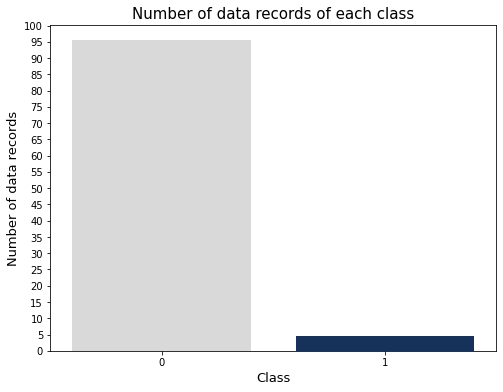

In [ ]:
# Visualize number of data records of each class (target column)
visualize_target_class(df)

**Comment:** Data is imbalanced, number of records belonging to class=1 accounts for only 4.48%.

##### **forecasting_period variable**

In [ ]:
list_forecasting_period = df['forecasting_period'].astype('int').unique().tolist()
print('forecasting_period includes {} values:'.format(len(list_forecasting_period)), sorted(list_forecasting_period))

forecasting_period includes 4 values: [1, 2, 3, 4]


File train.csv
--------------



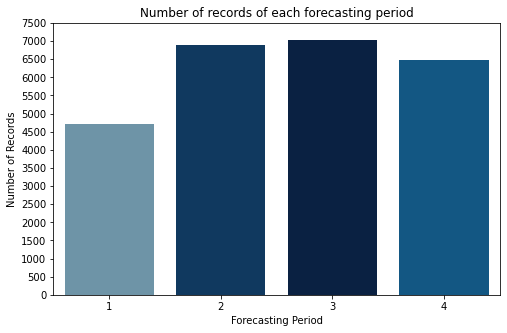

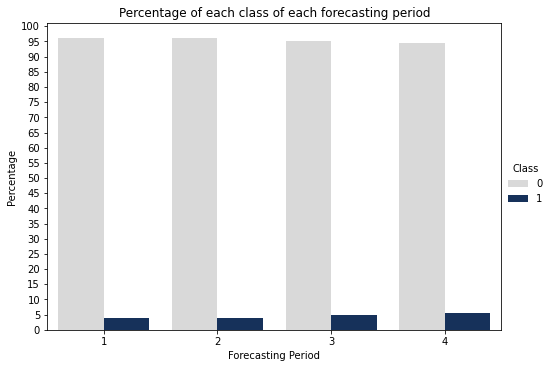


Statistics according to forecasting period


,Number of Records,Non bankrupt,Bankrupt,Percentage of Non bankrupt,Percentage of Bankrupt
Forecasting Period,,,,,
1,4712,4536,176,96.26486,3.73514
2,6900,6636,264,96.17391,3.82609
3,7018,6683,335,95.22656,4.77344
4,6491,6140,351,94.59251,5.40749




File test.csv
--------------



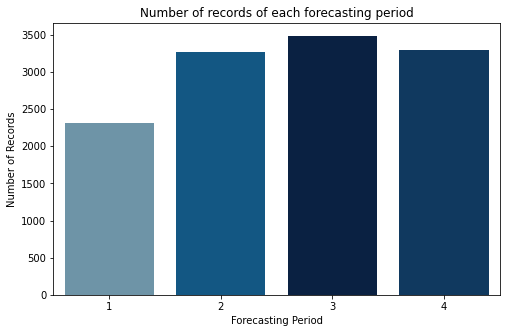


Statistics according to forecasting period


,Number of Records
Forecasting Period,
1,2315
2,3273
3,3485
4,3301


In [ ]:
print('File train.csv')
print('--------------\n')
display(forecasting_period_statistics(df, is_test_set=False))
print('\n\nFile test.csv')
print('--------------\n')
display(forecasting_period_statistics(test_df, is_test_set=True))


#### **1.2.2. Numerical variable analysis**

##### **Boxplot**

File train.csv
--------------



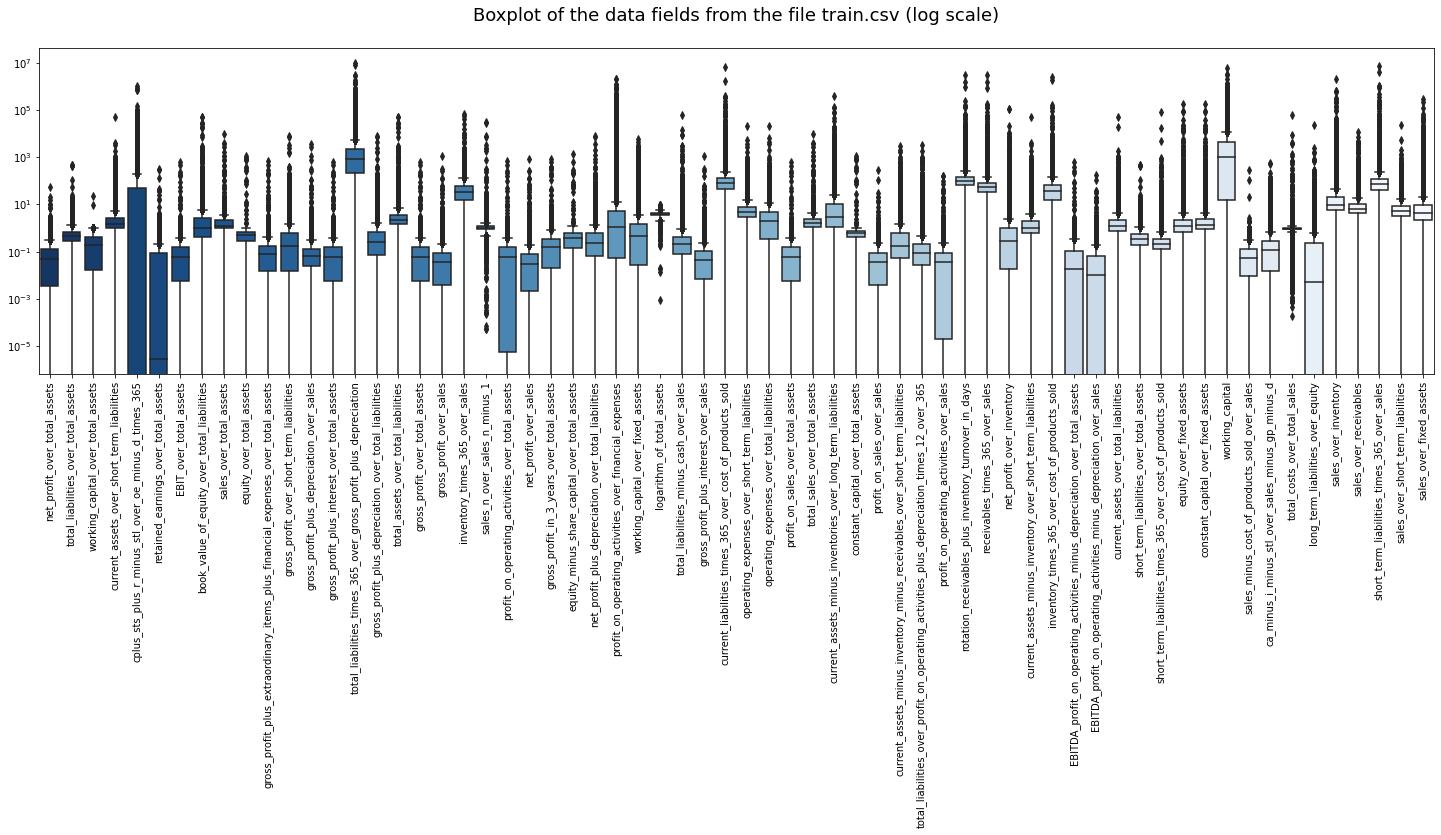



File test.csv
--------------



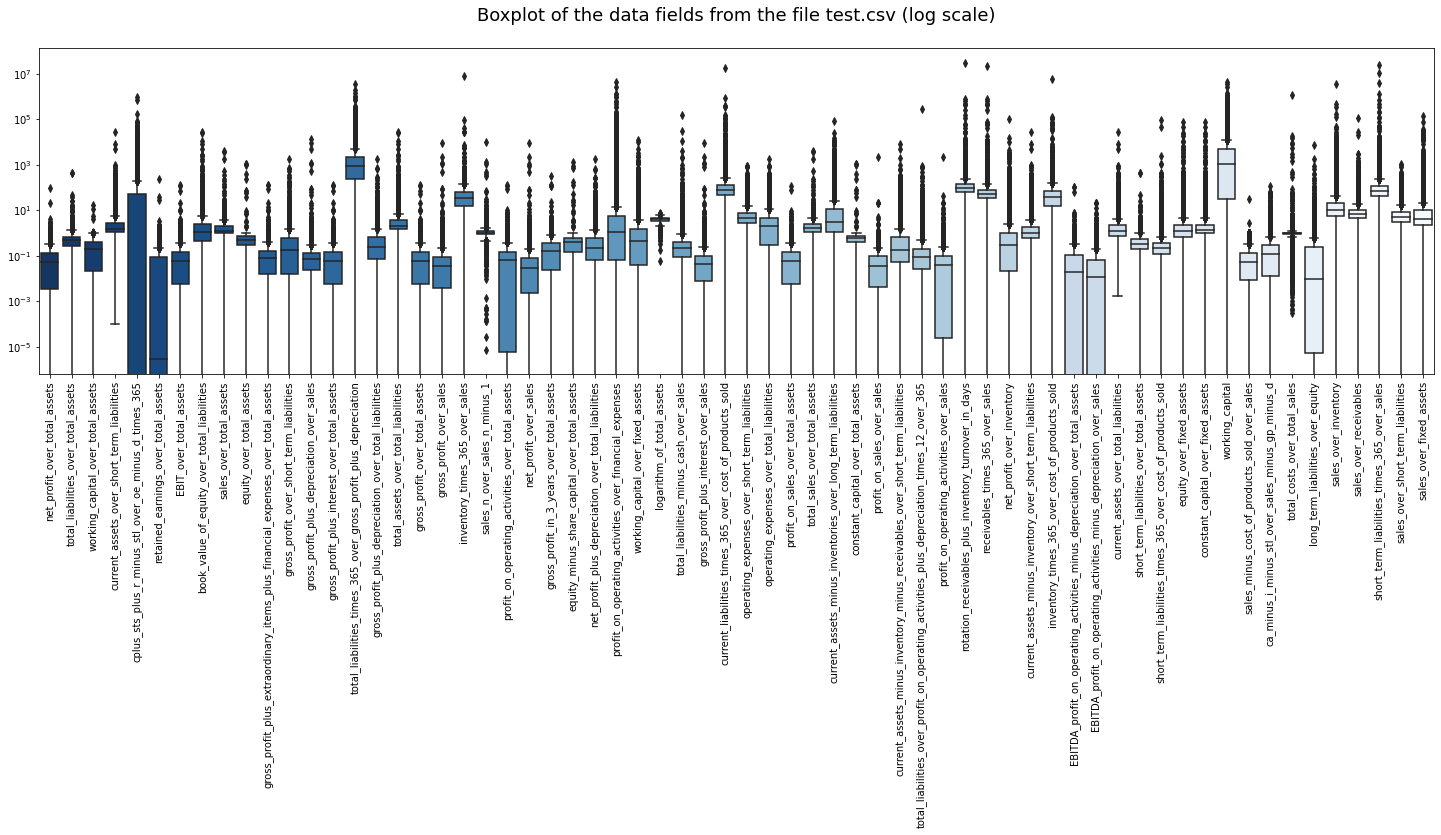

In [ ]:
print('File train.csv')
print('--------------\n')
display(visualize_boxplot(df, title_boxplot='of the data fields from the file train.csv'))
print('\n\nFile test.csv')
print('--------------\n')
display(visualize_boxplot(test_df, title_boxplot='of the data fields from the file test.csv'))

**Comment:** Data range of data fields is very large and there are many outliers.

##### **Histogram**

File train.csv
--------------



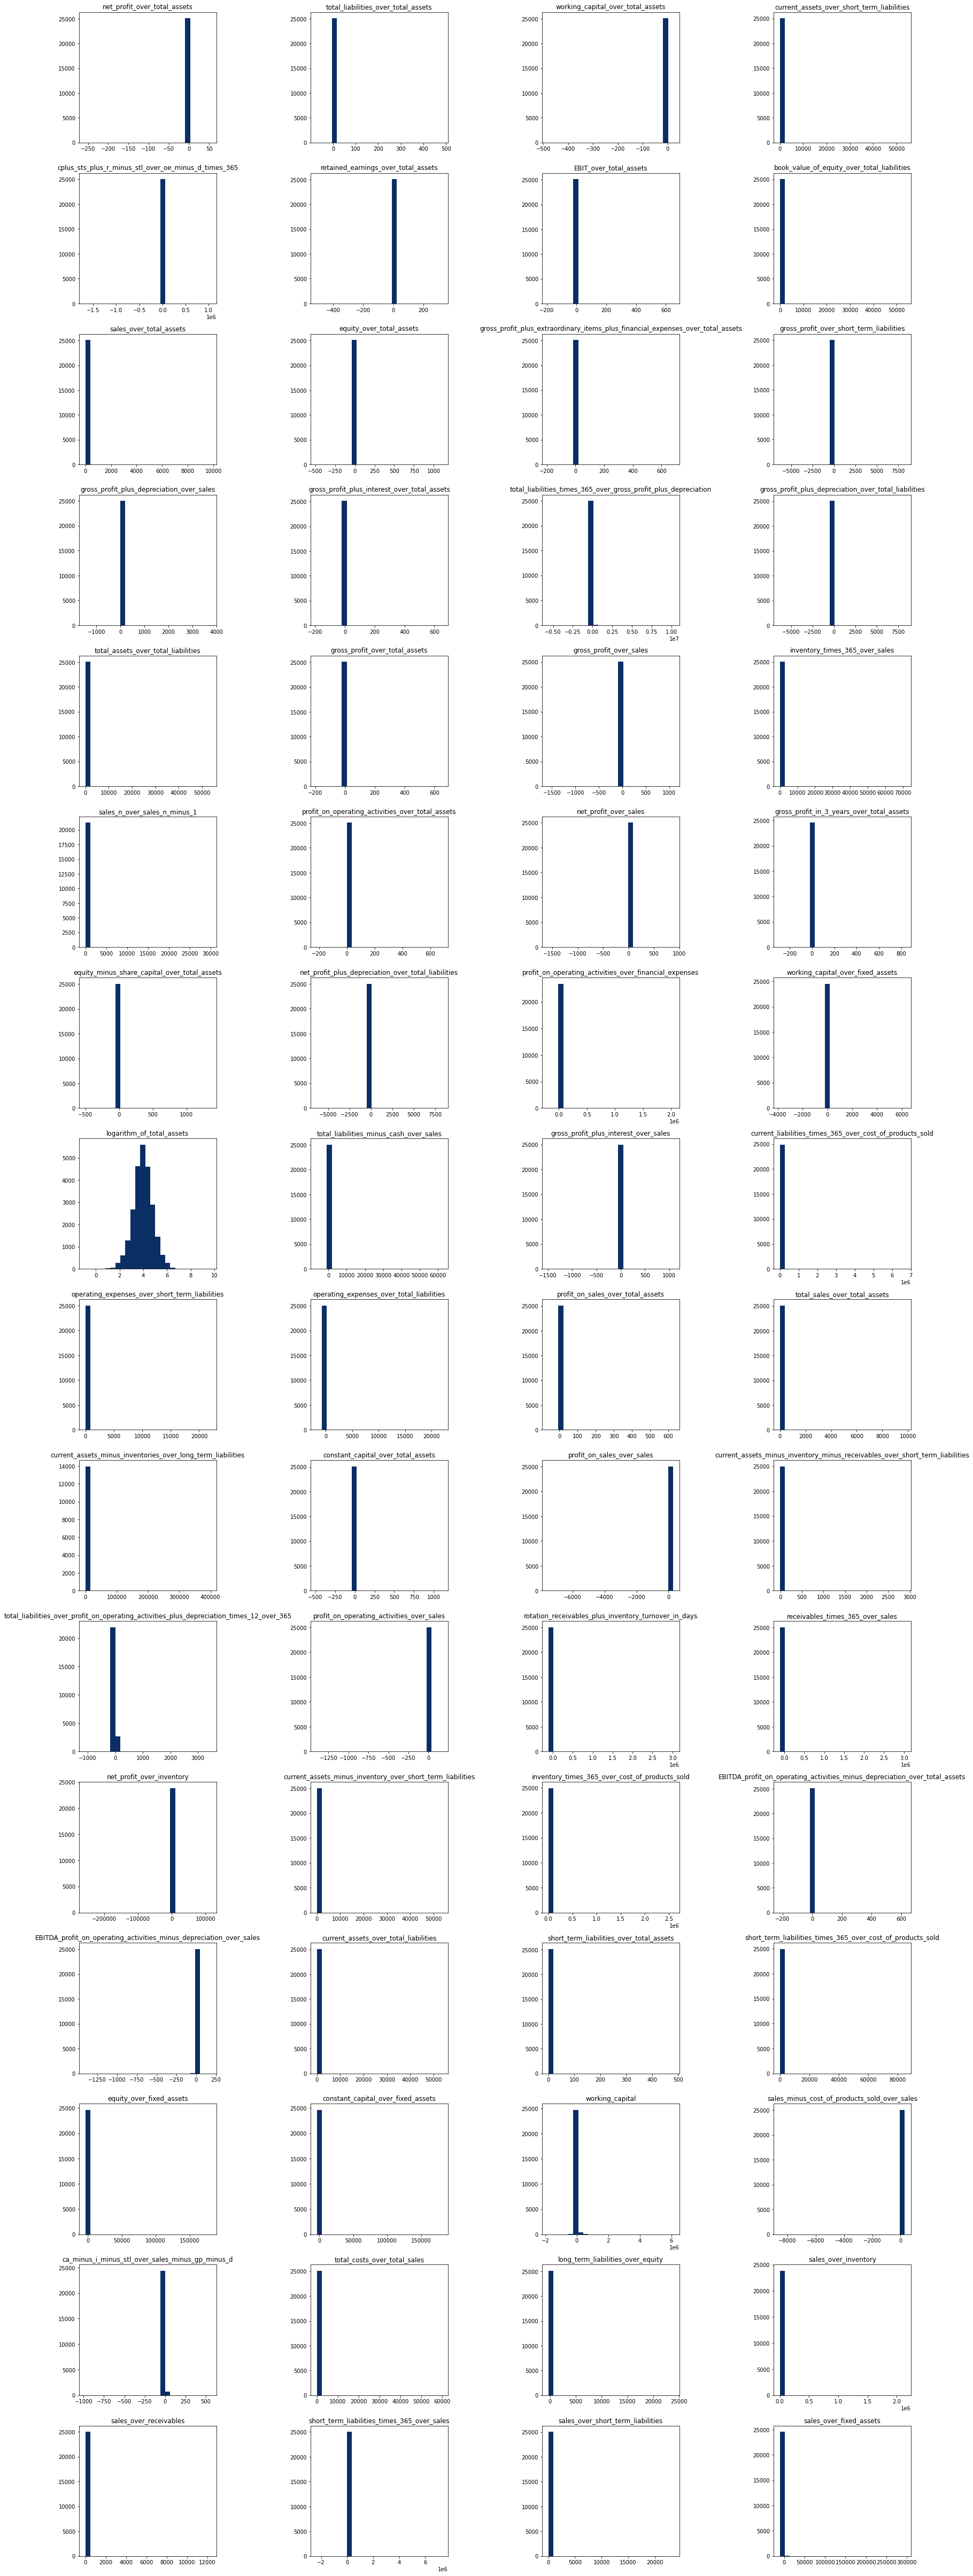



File test.csv
--------------



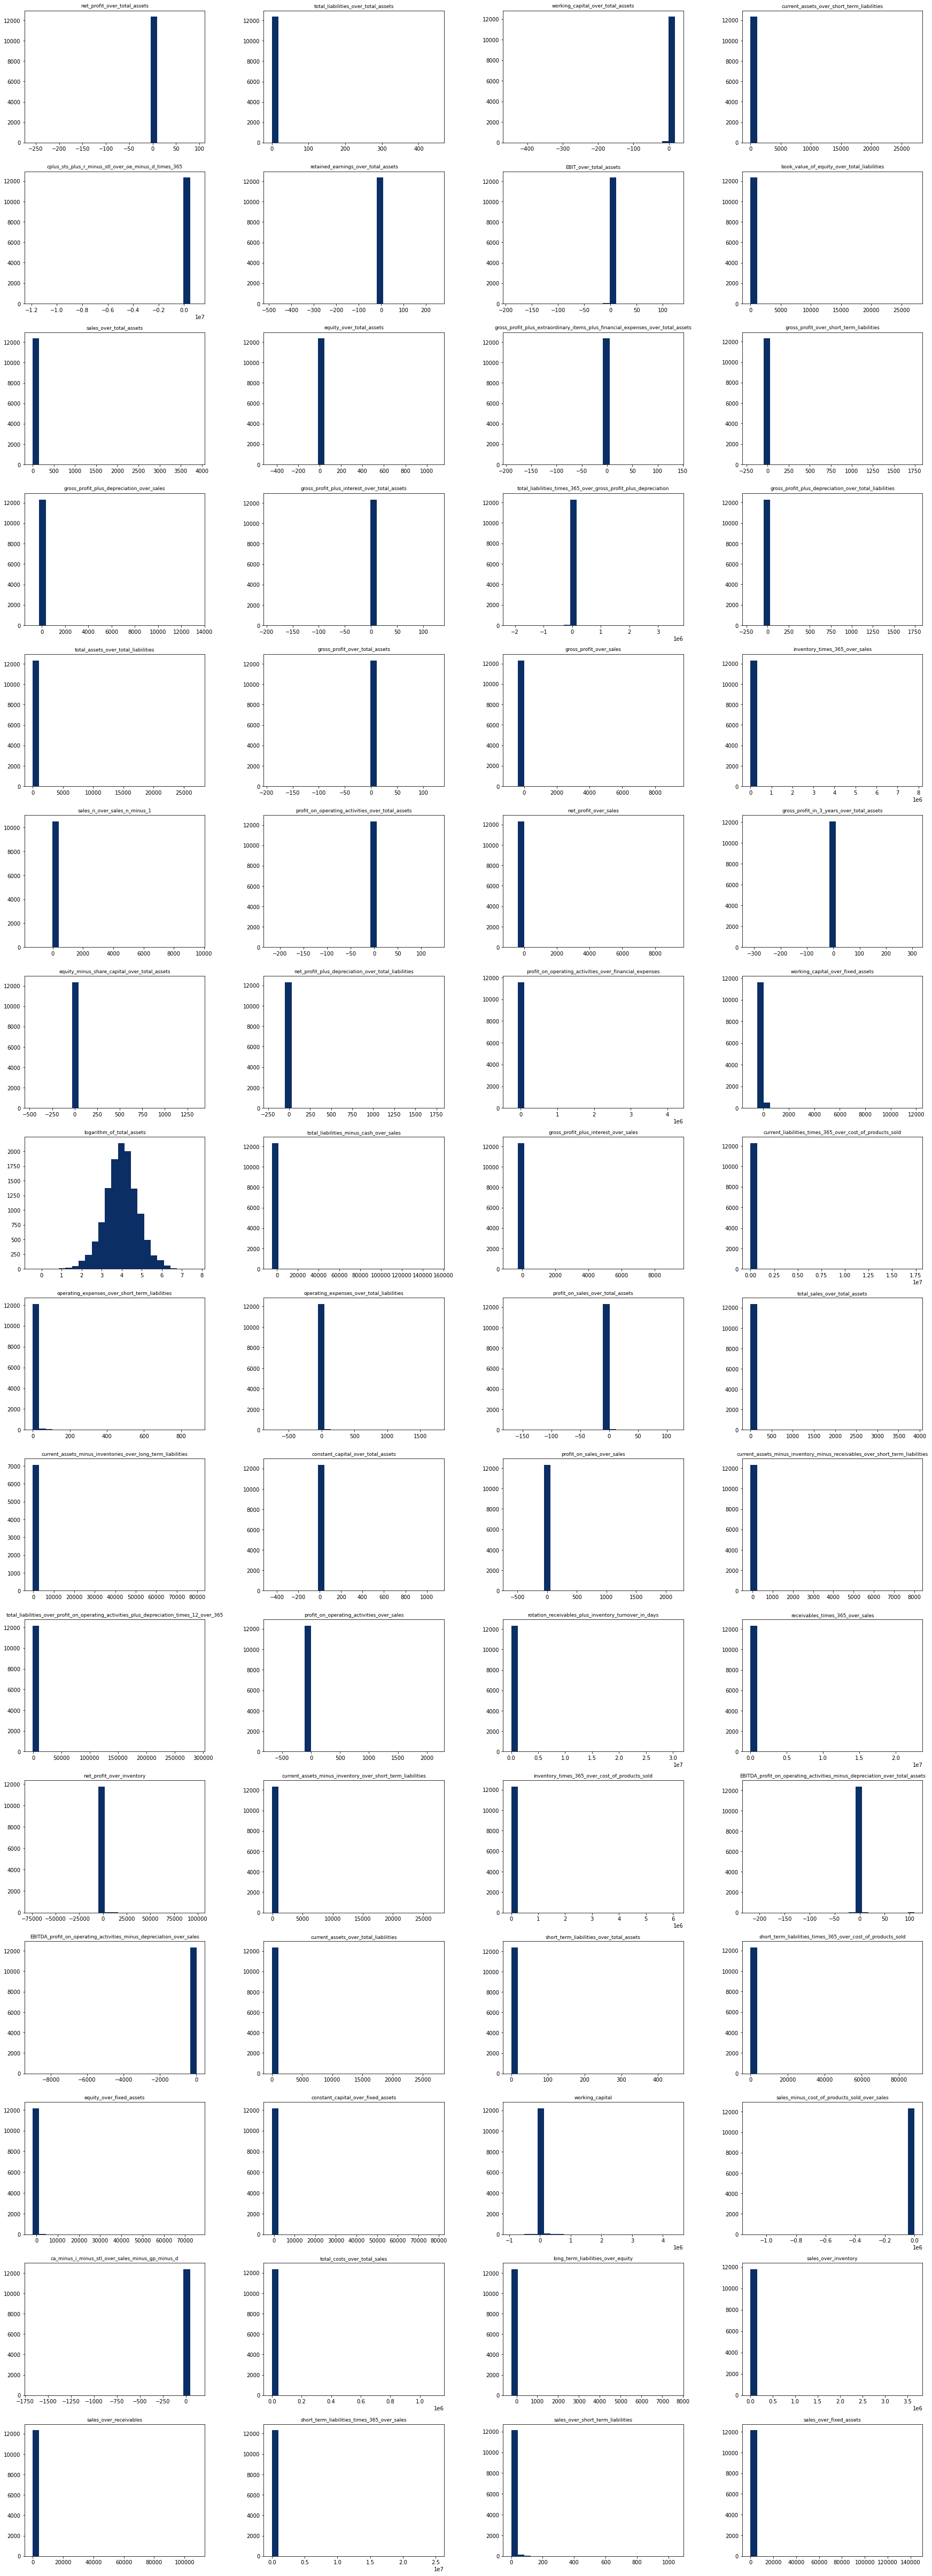

In [ ]:
print('File train.csv')
print('--------------\n')
display(visualize_histogram(df))
print('\n\nFile test.csv')
print('--------------\n')
display(visualize_histogram(test_df))

**Comment:** It can be seen that, except for `logarithm_of_total_assets` column, the remaining columns have a very skewed distribution. This is also influenced by outliers.

##### **Null values**

File train.csv
--------------



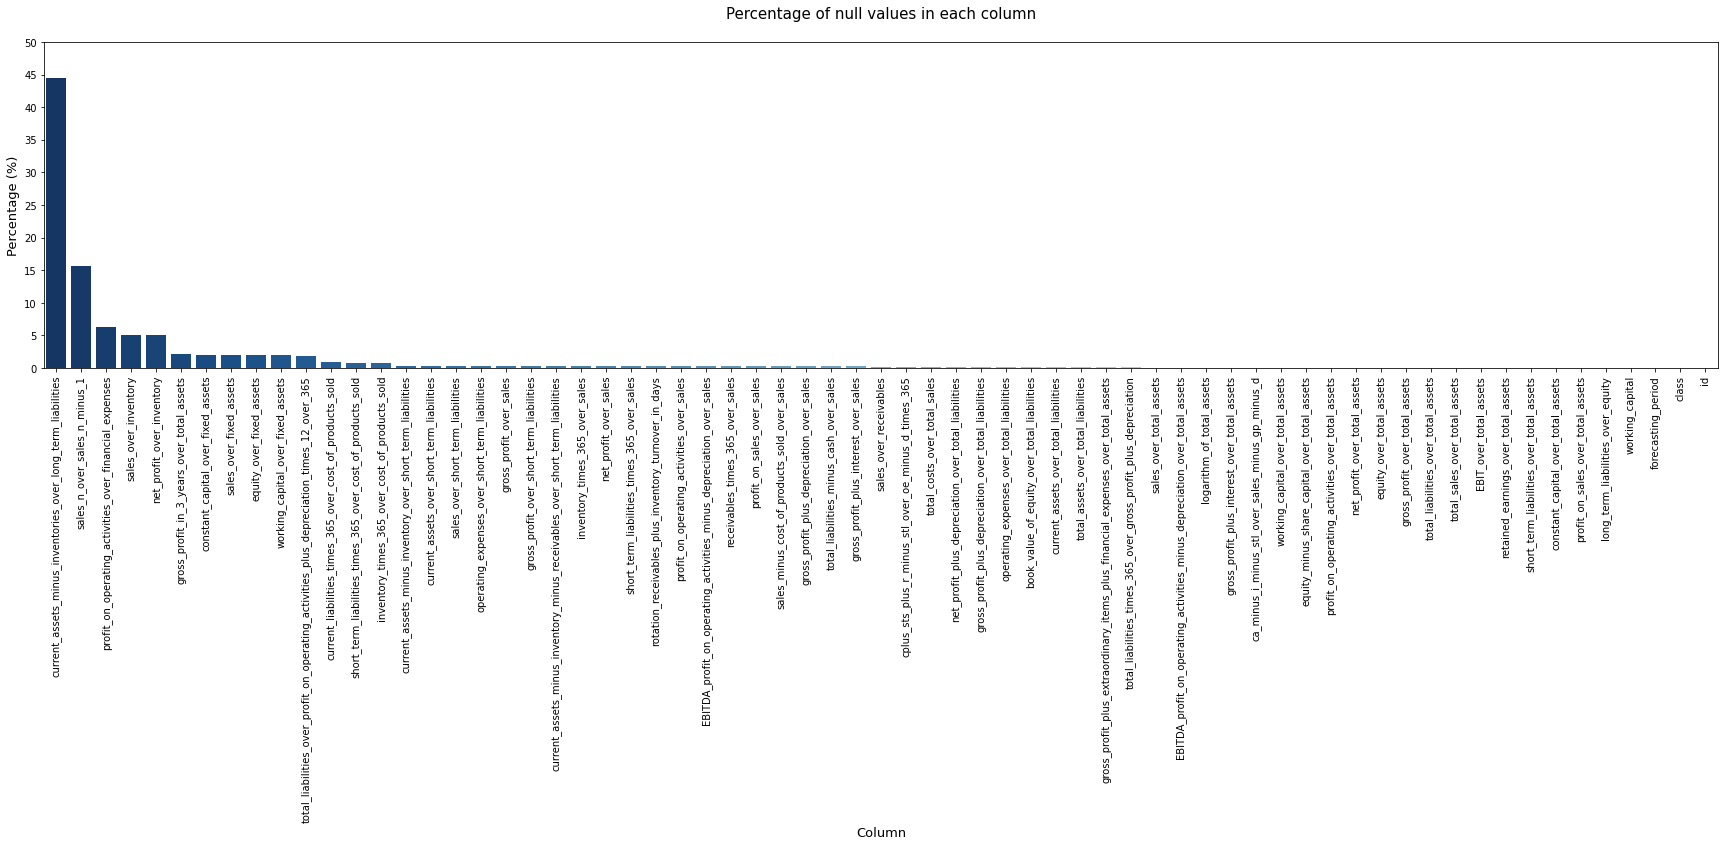



File test.csv
--------------



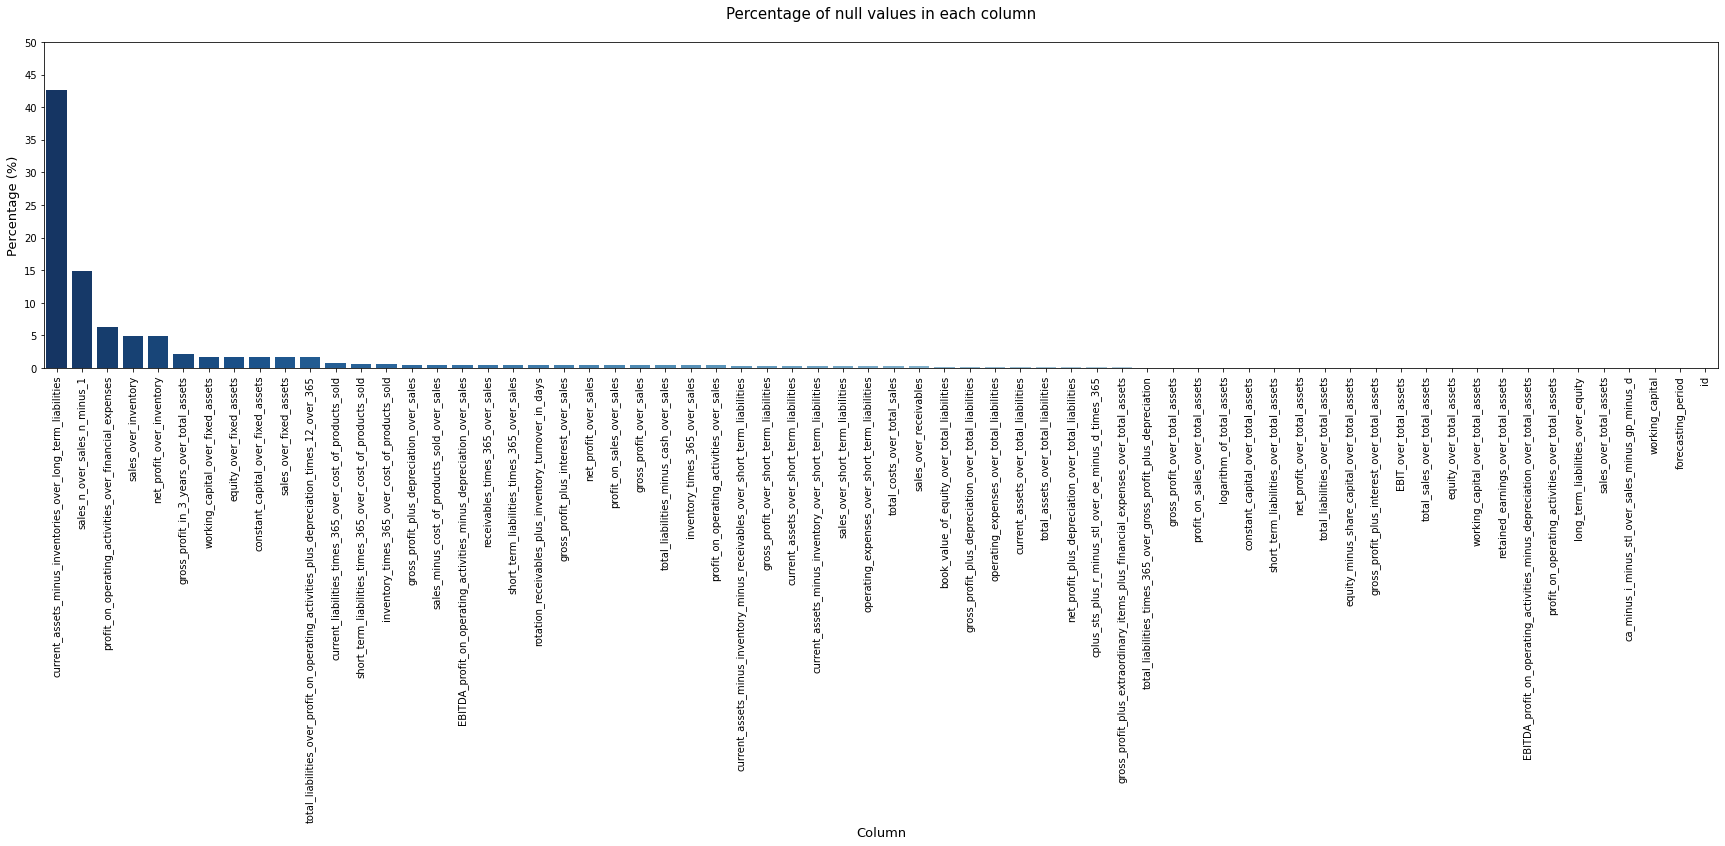

In [ ]:
null_df = check_null_values(df)
null_test_df = check_null_values(test_df)

print('File train.csv')
print('--------------\n')
display(visualize_percentage_null_values(null_df))
print('\n\nFile test.csv')
print('--------------\n')
display(visualize_percentage_null_values(null_test_df))

In [ ]:
print('File train.csv')
print('--------------')
display(null_df.T)
print('\n\nFile test.csv')
print('--------------')
display(null_test_df.T)

File train.csv
--------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66
column_name,current_assets_minus_inventories_over_long_term_liabilities,sales_n_over_sales_n_minus_1,profit_on_operating_activities_over_financial_expenses,sales_over_inventory,net_profit_over_inventory,gross_profit_in_3_years_over_total_assets,constant_capital_over_fixed_assets,sales_over_fixed_assets,equity_over_fixed_assets,working_capital_over_fixed_assets,total_liabilities_over_profit_on_operating_activities_plus_depreciation_times_12_over_365,current_liabilities_times_365_over_cost_of_products_sold,short_term_liabilities_times_365_over_cost_of_products_sold,inventory_times_365_over_cost_of_products_sold,current_assets_minus_inventory_over_short_term_liabilities,current_assets_over_short_term_liabilities,sales_over_short_term_liabilities,operating_expenses_over_short_term_liabilities,gross_profit_over_sales,gross_profit_over_short_term_liabilities,current_assets_minus_inventory_minus_receivables_over_short_term_liabilities,inventory_times_365_over_sales,net_profit_over_sales,short_term_liabilities_times_365_over_sales,rotation_receivables_plus_inventory_turnover_in_days,profit_on_operating_activities_over_sales,EBITDA_profit_on_operating_activities_minus_depreciation_over_sales,receivables_times_365_over_sales,profit_on_sales_over_sales,sales_minus_cost_of_products_sold_over_sales,gross_profit_plus_depreciation_over_sales,total_liabilities_minus_cash_over_sales,gross_profit_plus_interest_over_sales,sales_over_receivables,cplus_sts_plus_r_minus_stl_over_oe_minus_d_times_365,total_costs_over_total_sales,net_profit_plus_depreciation_over_total_liabilities,gross_profit_plus_depreciation_over_total_liabilities,operating_expenses_over_total_liabilities,book_value_of_equity_over_total_liabilities,current_assets_over_total_liabilities,total_assets_over_total_liabilities,gross_profit_plus_extraordinary_items_plus_financial_expenses_over_total_assets,total_liabilities_times_365_over_gross_profit_plus_depreciation,sales_over_total_assets,EBITDA_profit_on_operating_activities_minus_depreciation_over_total_assets,logarithm_of_total_assets,gross_profit_plus_interest_over_total_assets,ca_minus_i_minus_stl_over_sales_minus_gp_minus_d,working_capital_over_total_assets,equity_minus_share_capital_over_total_assets,profit_on_operating_activities_over_total_assets,net_profit_over_total_assets,equity_over_total_assets,gross_profit_over_total_assets,total_liabilities_over_total_assets,total_sales_over_total_assets,EBIT_over_total_assets,retained_earnings_over_total_assets,short_term_liabilities_over_total_assets,constant_capital_over_total_assets,profit_on_sales_over_total_assets,long_term_liabilities_over_equity,working_capital,forecasting_period,class,id
number_of_null_values,11153,3911,1600,1282,1279,522,491,491,491,491,457,224,185,184,79,78,78,78,78,78,78,77,77,77,77,77,77,77,77,77,77,77,77,57,57,53,50,50,49,49,49,49,26,22,7,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,0,0,0
percentage,44.397,15.569,6.369,5.103,5.091,2.078,1.955,1.955,1.955,1.955,1.819,0.892,0.736,0.732,0.314,0.31,0.31,0.31,0.31,0.31,0.31,0.307,0.307,0.307,0.307,0.307,0.307,0.307,0.307,0.307,0.307,0.307,0.307,0.227,0.227,0.211,0.199,0.199,0.195,0.195,0.195,0.195,0.103,0.088,0.028,0.016,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.004,0.0,0.0,0.0




File test.csv
--------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
column_name,current_assets_minus_inventories_over_long_term_liabilities,sales_n_over_sales_n_minus_1,profit_on_operating_activities_over_financial_expenses,sales_over_inventory,net_profit_over_inventory,gross_profit_in_3_years_over_total_assets,working_capital_over_fixed_assets,equity_over_fixed_assets,constant_capital_over_fixed_assets,sales_over_fixed_assets,total_liabilities_over_profit_on_operating_activities_plus_depreciation_times_12_over_365,current_liabilities_times_365_over_cost_of_products_sold,short_term_liabilities_times_365_over_cost_of_products_sold,inventory_times_365_over_cost_of_products_sold,gross_profit_plus_depreciation_over_sales,sales_minus_cost_of_products_sold_over_sales,EBITDA_profit_on_operating_activities_minus_depreciation_over_sales,receivables_times_365_over_sales,short_term_liabilities_times_365_over_sales,rotation_receivables_plus_inventory_turnover_in_days,gross_profit_plus_interest_over_sales,net_profit_over_sales,profit_on_sales_over_sales,gross_profit_over_sales,total_liabilities_minus_cash_over_sales,inventory_times_365_over_sales,profit_on_operating_activities_over_sales,current_assets_minus_inventory_minus_receivables_over_short_term_liabilities,gross_profit_over_short_term_liabilities,current_assets_over_short_term_liabilities,current_assets_minus_inventory_over_short_term_liabilities,sales_over_short_term_liabilities,operating_expenses_over_short_term_liabilities,total_costs_over_total_sales,sales_over_receivables,book_value_of_equity_over_total_liabilities,gross_profit_plus_depreciation_over_total_liabilities,operating_expenses_over_total_liabilities,current_assets_over_total_liabilities,total_assets_over_total_liabilities,net_profit_plus_depreciation_over_total_liabilities,cplus_sts_plus_r_minus_stl_over_oe_minus_d_times_365,gross_profit_plus_extraordinary_items_plus_financial_expenses_over_total_assets,total_liabilities_times_365_over_gross_profit_plus_depreciation,gross_profit_over_total_assets,profit_on_sales_over_total_assets,logarithm_of_total_assets,constant_capital_over_total_assets,short_term_liabilities_over_total_assets,net_profit_over_total_assets,total_liabilities_over_total_assets,equity_minus_share_capital_over_total_assets,gross_profit_plus_interest_over_total_assets,EBIT_over_total_assets,total_sales_over_total_assets,equity_over_total_assets,working_capital_over_total_assets,retained_earnings_over_total_assets,EBITDA_profit_on_operating_activities_minus_depreciation_over_total_assets,profit_on_operating_activities_over_total_assets,long_term_liabilities_over_equity,sales_over_total_assets,ca_minus_i_minus_stl_over_sales_minus_gp_minus_d,working_capital,forecasting_period,id
number_of_null_values,5283,1840,773,602,600,265,214,214,214,214,213,98,80,78,50,50,50,50,50,50,50,50,50,50,50,50,50,35,35,35,35,35,35,31,30,27,27,27,27,27,27,21,15,8,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,0,0,0
percentage,42.694,14.87,6.247,4.865,4.849,2.142,1.729,1.729,1.729,1.729,1.721,0.792,0.647,0.63,0.404,0.404,0.404,0.404,0.404,0.404,0.404,0.404,0.404,0.404,0.404,0.404,0.404,0.283,0.283,0.283,0.283,0.283,0.283,0.251,0.242,0.218,0.218,0.218,0.218,0.218,0.218,0.17,0.121,0.065,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.008,0.008,0.008,0.0,0.0,0.0


**Comment:**
* 5 columns `current_assets_minus_inventories_over_long_term_liabilities`, `sales_n_over_sales_n_minus_1`, `profit_on_operating_activities_over_financial_expenses`, `sales_over_inventory`, `net_profit_over_inventory` have the most null values.

- Column `current_assets_minus_inventories_over_long_term_liabilities` has the most null values up to 44.397% (in train.csv file), 21.03% (in test.csv file).

## **II. Data preparation**

### **2.1. Handling outliers**

**Convert outliers to upper limit and lower limit of each field**

In [ ]:
list_numeric_columns = df.select_dtypes(include='number').columns.tolist()

for column in list_numeric_columns:
    df[column] = BoxplotOutlierClipper().fit_transform(df[column])
    test_df[column] = BoxplotOutlierClipper().fit_transform(test_df[column])

File train.csv
--------------



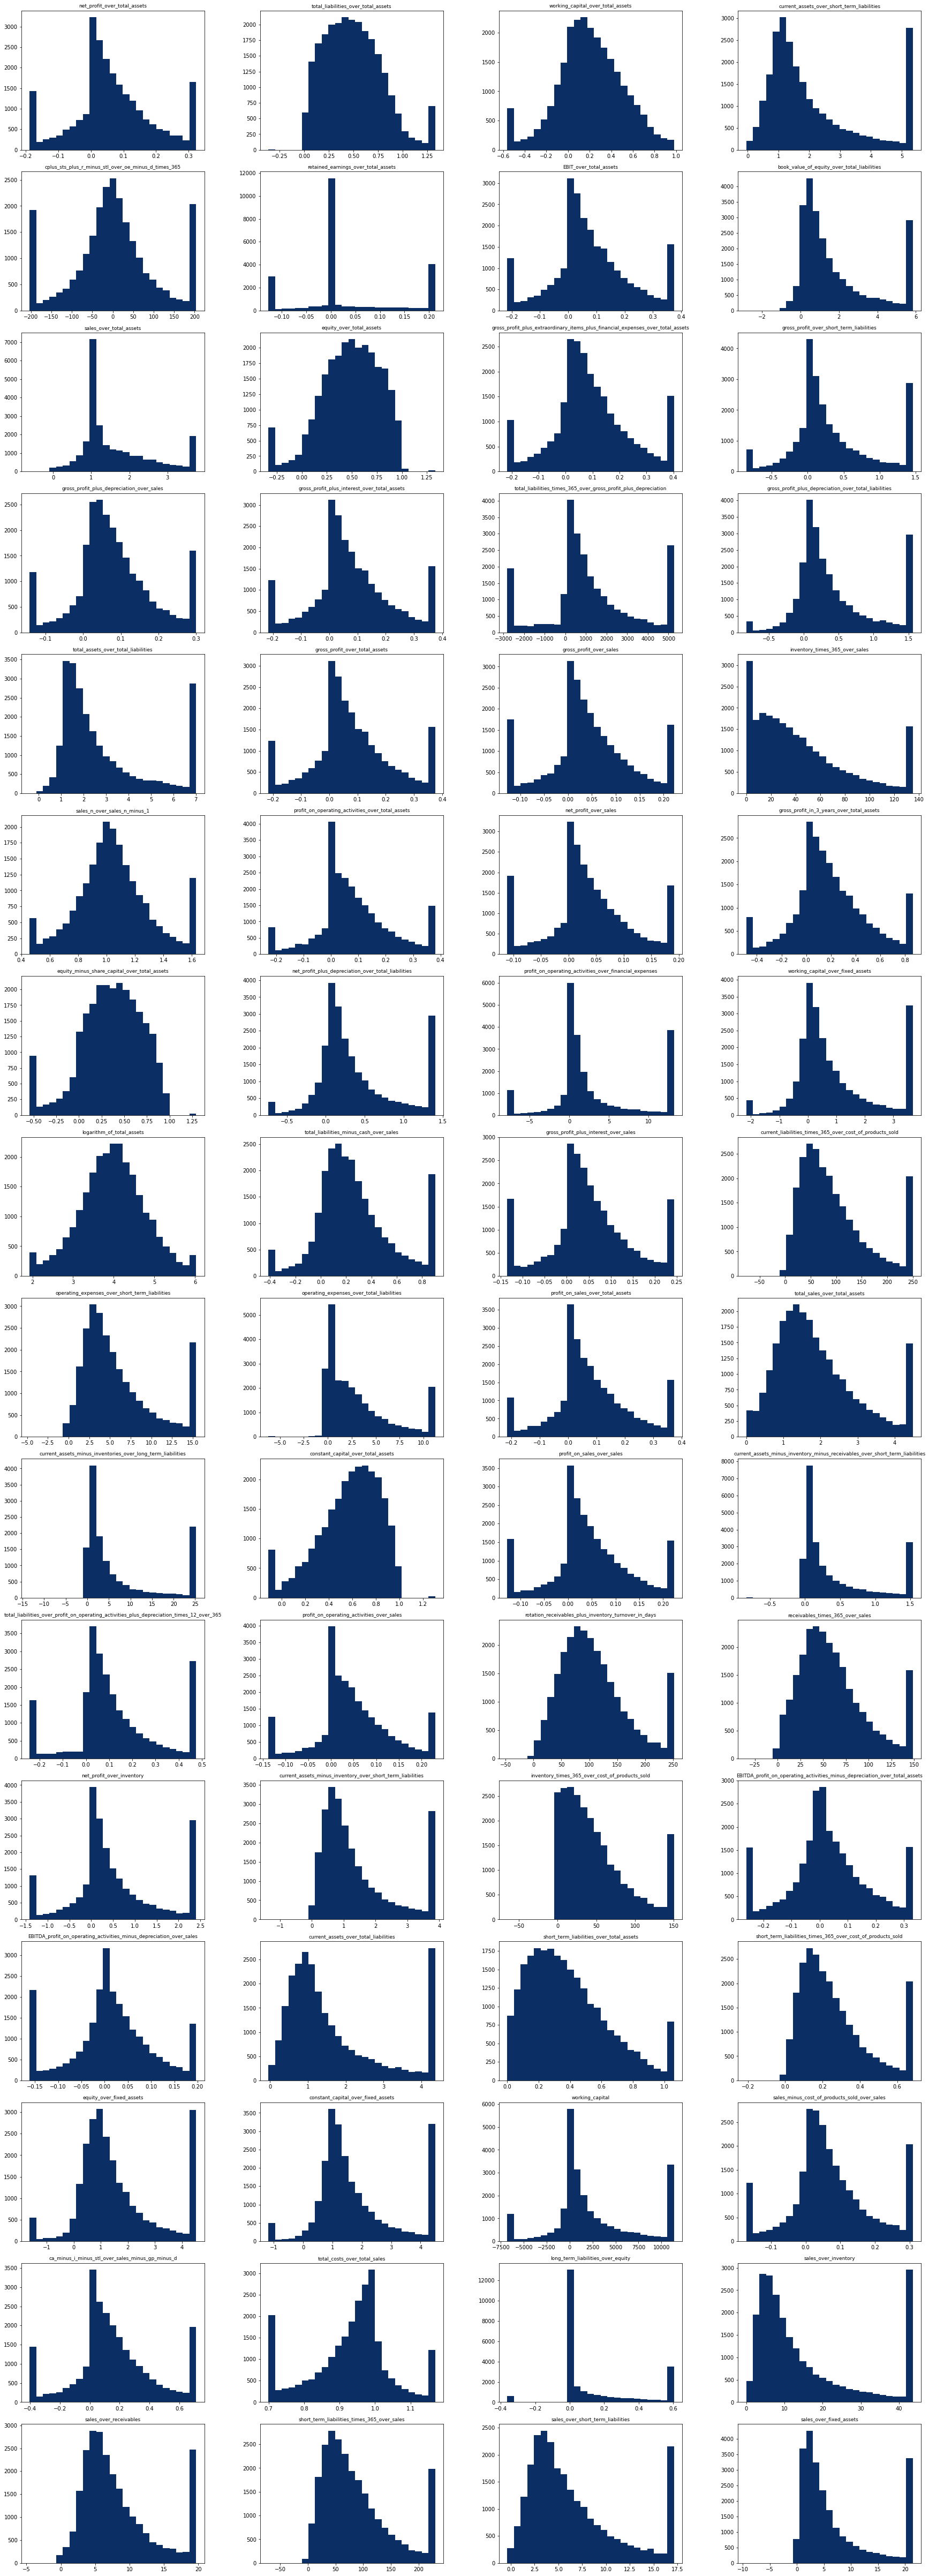



File test.csv
--------------



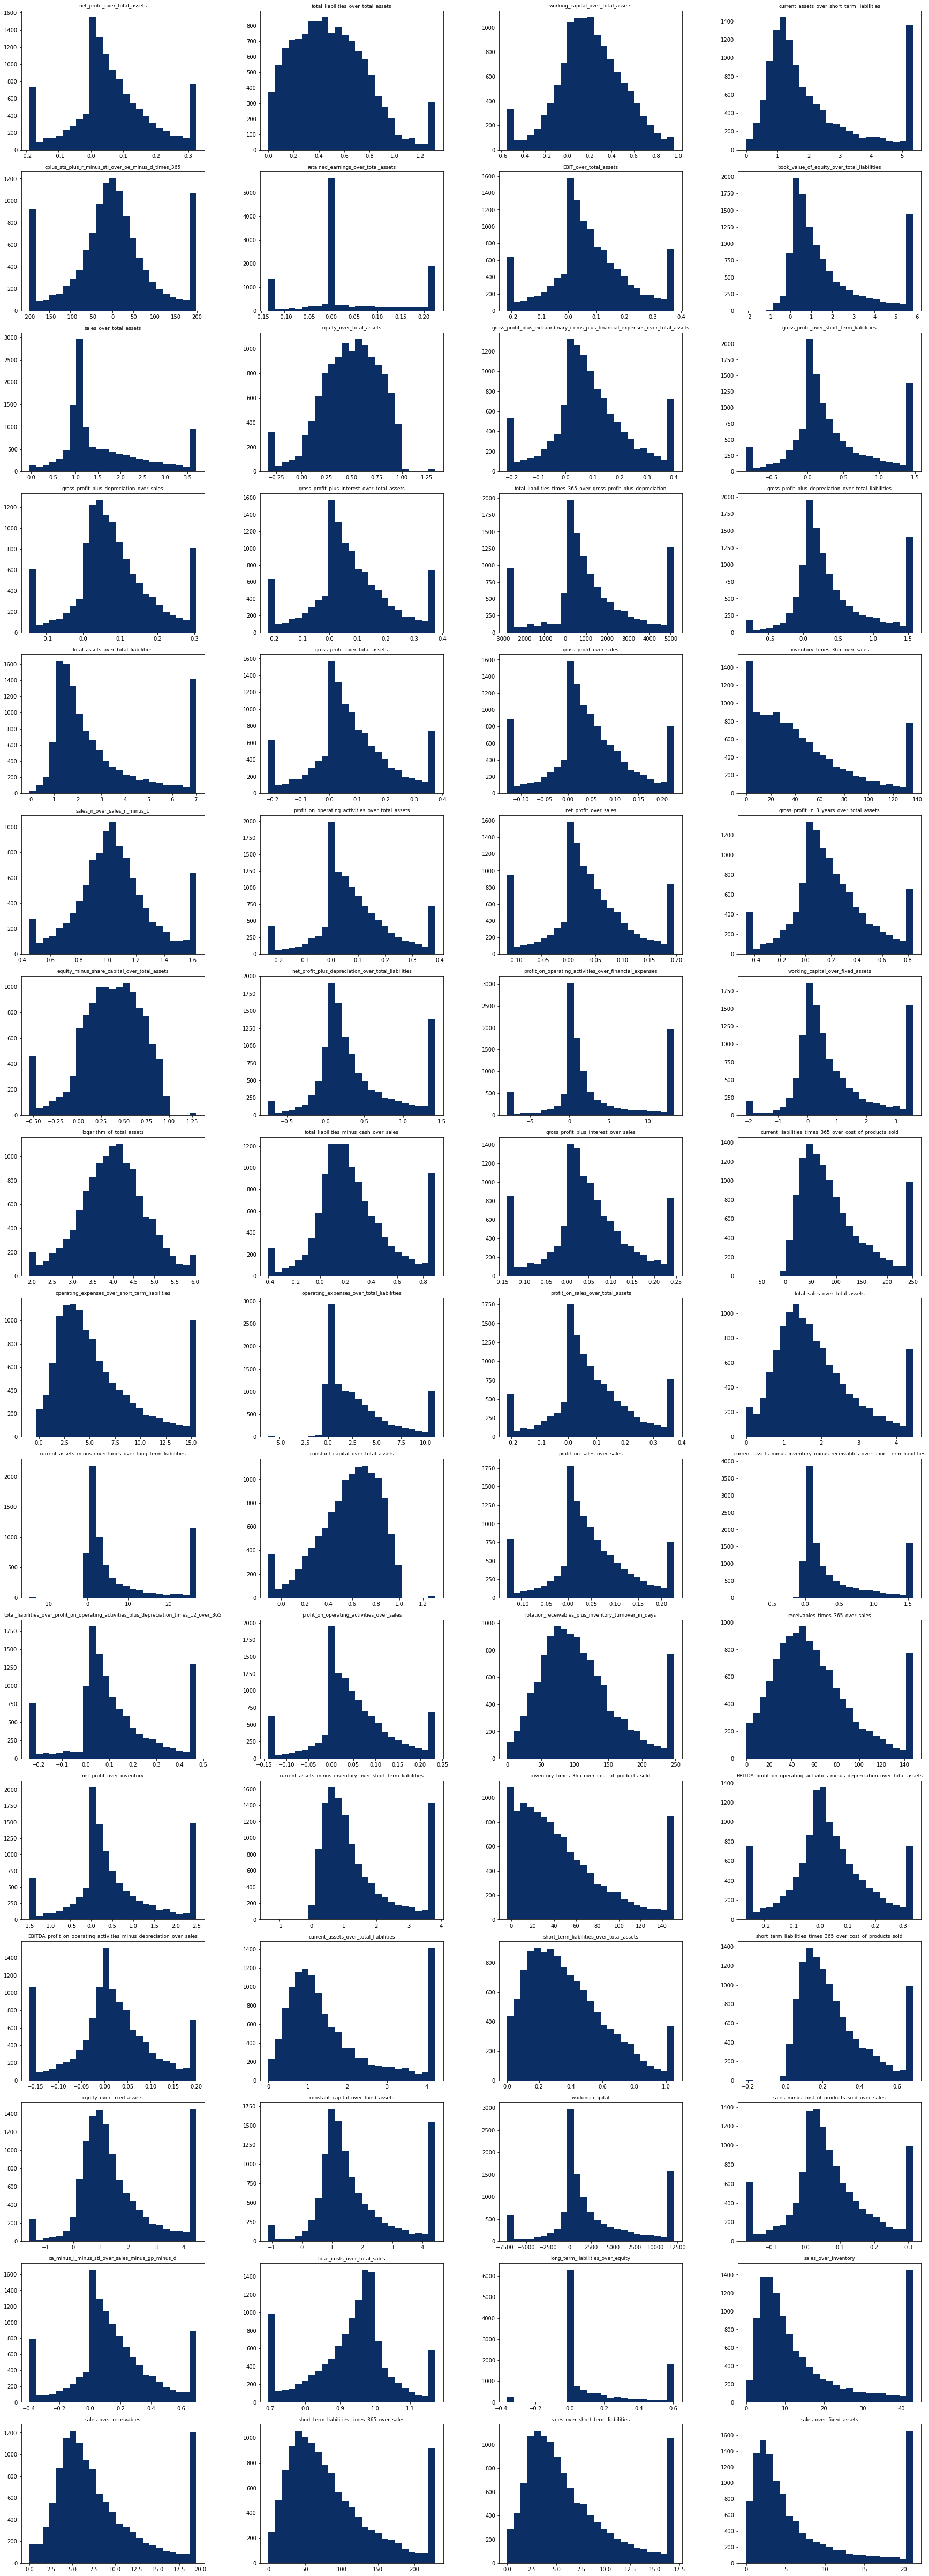

In [ ]:
print('File train.csv')
print('--------------\n')
display(visualize_histogram(df))
print('\n\nFile test.csv')
print('--------------\n')
display(visualize_histogram(test_df))

**Comment:** The data has been less skewed than the distribution of the original data.

### **2.2. Feature selection**

**Remove column containing the most null values and `id` column:**
* Remove column containing the most null values `current_assets_minus_inventories_over_long_term_liabilities`.
* Remove `id` column because this column only helps to identify but has no meaning in modeling.

In [ ]:
dropped_columns = ['id'] + null_df.head(1)['column_name'].tolist() 
new_df = keep_the_necessary_columns(df, dropped_columns)
new_test_df = keep_the_necessary_columns(test_df, dropped_columns)

print('File train.csv - New Shape:', new_df.shape)
print('File test.csv - New Shape:', new_test_df.shape) 

File train.csv - New Shape: (25121, 65)
File test.csv - New Shape: (12374, 64)


**Importance of features according to CatBoost**

In [ ]:
feature_importance_full_df, feature_importance_df = display_feature_importance(new_df)
print(feature_importance_df.shape)
feature_importance_df

(63, 2)


,feature_importance,feature_name
33,13.810129,operating_expenses_over_total_liabilities
26,10.322907,profit_on_operating_activities_over_financial_expenses
44,5.617164,current_assets_minus_inventory_over_short_term_liabilities
4,5.473922,cplus_sts_plus_r_minus_stl_over_oe_minus_d_times_365
56,3.869190,total_costs_over_total_sales
28,2.938278,logarithm_of_total_assets
8,2.669610,sales_over_total_assets
5,2.579797,retained_earnings_over_total_assets
23,2.570912,gross_profit_in_3_years_over_total_assets
20,2.374587,sales_n_over_sales_n_minus_1


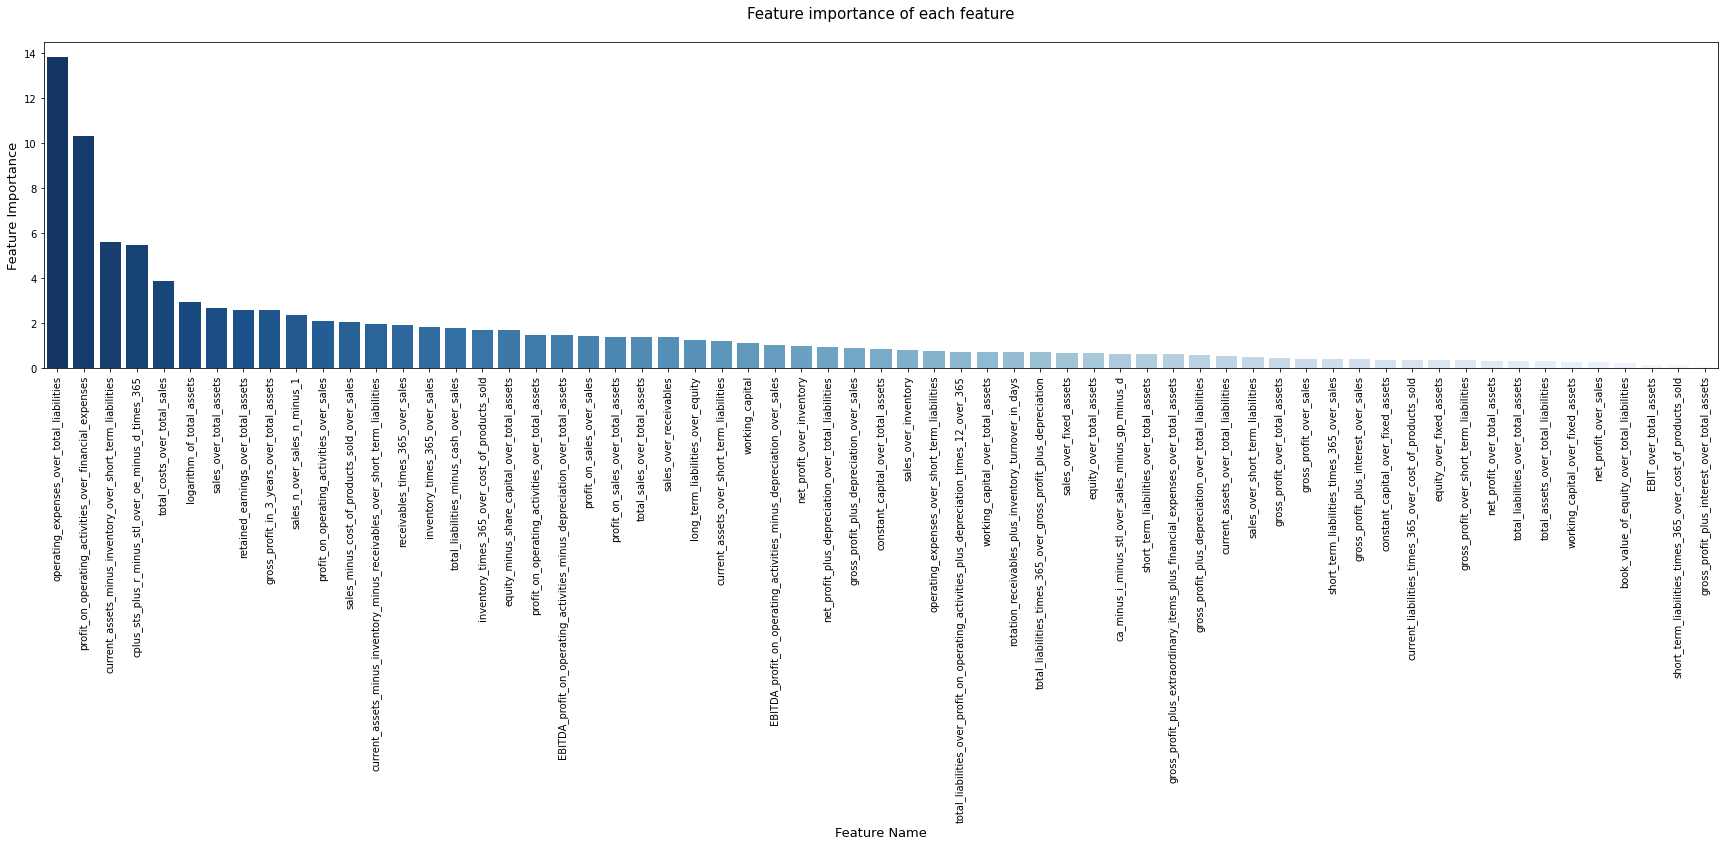

In [ ]:
# Visualize bar graph of feature importance of each feature
fig, ax = plt.subplots(figsize=(30, 6))
sns.barplot(
    y='feature_importance',
    x='feature_name',
    data=feature_importance_df,
    palette='Blues_r',
    ax=ax
)
ax.set_title('Feature importance of each feature\n', fontsize=15)
ax.set_xlabel('Feature Name', fontsize=13)
ax.set_ylabel('Feature Importance', fontsize=13)
ax.set_xticklabels(feature_importance_df.feature_name, rotation=90)

plt.show()

**Results of 3 models CatBoost, Light GBM, MLP by number of selected features (based on importance of features)**

In [ ]:
feature_score_df = select_feature(new_df, feature_importance_df)

In [ ]:
feature_score_df['total'] = feature_score_df['f1_valid_CB'] + feature_score_df['f1_valid_LGBM'] + feature_score_df['f1_valid_MLP']
feature_score_sorted_df = feature_score_df.sort_values(by=['total', 'f1_valid_CB'], ascending=False)
feature_score_sorted_df

,number_of_selected_columns,number_of_dropped_columns,f1_train_CB,f1_train_LGBM,f1_train_MLP,f1_valid_CB,f1_valid_LGBM,f1_valid_MLP,total
30,31,32,0.936246,0.959584,0.949309,0.697143,0.658892,0.737113,2.093148
35,36,27,0.937574,0.964963,0.958525,0.672464,0.658824,0.743142,2.074429
52,53,10,0.939376,0.966781,0.983146,0.689655,0.668622,0.711688,2.069965
26,27,36,0.928656,0.954756,0.937136,0.682081,0.649123,0.731343,2.062547
40,41,22,0.937500,0.963218,0.981408,0.687861,0.676301,0.695431,2.059593
36,37,26,0.938199,0.962579,0.957055,0.678161,0.678261,0.701923,2.058345
27,28,35,0.929293,0.961383,0.948585,0.685879,0.648968,0.718826,2.053673
28,29,34,0.931832,0.954150,0.942874,0.693410,0.628743,0.725926,2.048078
31,32,31,0.934358,0.961383,0.955568,0.674352,0.643068,0.727735,2.045155
47,48,15,0.937500,0.969697,0.987100,0.678261,0.649123,0.711688,2.039072


**Remove the 32 least important features**

In [ ]:
list_dropped_columns_FI = feature_importance_df.tail(32).feature_name.tolist()
X_train_valid = new_df.drop(list_dropped_columns_FI, axis=1)
X_test = new_test_df.drop(list_dropped_columns_FI, axis=1)

print('File train.csv - New Shape:', X_train_valid.shape)
print('File test.csv - New Shape:', X_test.shape) 

File train.csv - New Shape: (25121, 33)
File test.csv - New Shape: (12374, 32)


**Comment:** Use the remaining 32 features (excluding `class`) - the features with the best importance according to CatBoost to build the model. Includes the following features:

In [ ]:
feature_importance_df.head(31).feature_name.tolist() + ['forecasting_period']

['operating_expenses_over_total_liabilities',
 'profit_on_operating_activities_over_financial_expenses',
 'current_assets_minus_inventory_over_short_term_liabilities',
 'cplus_sts_plus_r_minus_stl_over_oe_minus_d_times_365',
 'total_costs_over_total_sales',
 'logarithm_of_total_assets',
 'sales_over_total_assets',
 'retained_earnings_over_total_assets',
 'gross_profit_in_3_years_over_total_assets',
 'sales_n_over_sales_n_minus_1',
 'profit_on_operating_activities_over_sales',
 'sales_minus_cost_of_products_sold_over_sales',
 'current_assets_minus_inventory_minus_receivables_over_short_term_liabilities',
 'receivables_times_365_over_sales',
 'inventory_times_365_over_sales',
 'total_liabilities_minus_cash_over_sales',
 'inventory_times_365_over_cost_of_products_sold',
 'equity_minus_share_capital_over_total_assets',
 'profit_on_operating_activities_over_total_assets',
 'EBITDA_profit_on_operating_activities_minus_depreciation_over_total_assets',
 'profit_on_sales_over_sales',
 'profit_o

### **2.3. Train/Valid split**

In [ ]:
# Train-valid split data
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid.drop('class', axis=1),
    X_train_valid['class'].astype('int'),
    test_size=0.2,
    stratify=X_train_valid['class'].astype('int'),
    random_state=0
)

In [ ]:
# Check class=1/class=0 of y_train and y_valid
print('Train')
print(y_train.value_counts(normalize=True))
print('\n\nValid')
print(y_valid.value_counts(normalize=True))

Train
0    0.955165
1    0.044835
Name: class, dtype: float64


Valid
0    0.955224
1    0.044776
Name: class, dtype: float64


In [ ]:
print('Train data:', X_train.shape,  y_train.shape)
print('Valid data:', X_valid.shape,  y_valid.shape)

Train data: (20096, 32) (20096,)
Valid data: (5025, 32) (5025,)


In [ ]:
# Store 'forecasting_period' so that can check it later
X_train_forecasting_period = X_train['forecasting_period'] 
X_valid_forecasting_period = X_valid['forecasting_period'] 

### **2.4. Pipeline**


* **For numeric variable:** Normalize data using **StandardScaler** and fill  missing values with value **-9**.

* **For categorical variable:** Since there is no missing value, only one-hot encoding is performed.

In [ ]:
# Filter column names of categorical and numerical variables
cat_names = list(X_train.select_dtypes('category').columns)
num_names = list(X_train.select_dtypes('float').columns)

In [ ]:
# Pipeline for numerical variable
num_pl = Pipeline(
    steps=[
        ('scaler', StandardScaler()),            
        ('imputer', SimpleImputer(strategy='constant', fill_value=-9)),
    ]
)

# Pipeline for categorical variable
cat_pl= Pipeline(
    steps=[
        ('onehot', OneHotEncoder(drop='first')),
    ]
)

# Combine 'num_pl' and 'cat_pl' to form a complete featured processor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pl, num_names), 
        ('cat', cat_pl, cat_names),
    ]
)

In [ ]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_valid_transformed = preprocessor.fit_transform(X_valid)

## **III. Modelling & Evaluation**

### **3.1. Default models & Results** 

#### **3.1.1. Default models** 

In [ ]:
CB_model = CatBoostClassifier(verbose=False, eval_metric='F1', random_state=0)
LGBM_model = lgb.LGBMClassifier(random_state=0)
MLP_model = MLPClassifier(random_state=0)

In [ ]:
list_models = [
    LogisticRegression(random_state=0),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=0),
    SVC(probability=True, random_state=0),
    RandomForestClassifier(random_state=0),
    AdaBoostClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0),
    XGBClassifier(random_state=0),
    MLP_model,
    LGBM_model,
    CB_model
]

list_name_models = [
    'LogisticRegression',
    'KNeighborsClassifier',
    'DecisionTreeClassifier',
    'SVM',
    'RandomForestClassifier',
    'AdaBoostClassifier',
    'GradientBoostingClassifier',
    'XGBClassifier',
    'MLPClassifier',
    'LGBMClassifier',
    'CatBoostClassifier'
]

**Train models**

In [ ]:
without_resampling_score_df = run_list_models(
    X_train, y_train,
    X_valid, y_valid,
    list_models=list_models,
    list_name_models=list_name_models,
    preprocessor=preprocessor,
    have_resample=False
)

#### **3.1.2. Results**

In [ ]:
without_resampling_score_df

,model,f1_train,f1_valid,recall_train,recall_valid,precision_train,precision_valid,accuracy_train,accuracy_valid
0,MLPClassifier,0.949309,0.737113,0.914539,0.635556,0.986826,0.877301,0.995621,0.979701
1,CatBoostClassifier,0.936246,0.697143,0.880133,0.542222,1.000000,0.976000,0.994626,0.978905
2,LGBMClassifier,0.959584,0.658892,0.922309,0.502222,1.000000,0.957627,0.996517,0.976716
3,XGBClassifier,0.630468,0.549521,0.463929,0.382222,0.983529,0.977273,0.975617,0.971940
4,GradientBoostingClassifier,0.644825,0.527331,0.480577,0.364444,0.979638,0.953488,0.976264,0.970746
5,DecisionTreeClassifier,1.000000,0.506667,1.000000,0.506667,1.000000,0.506667,1.000000,0.955821
6,RandomForestClassifier,0.999445,0.416667,0.998890,0.266667,1.000000,0.952381,0.999950,0.966567
7,SVM,0.469992,0.412587,0.308546,0.262222,0.985816,0.967213,0.968800,0.966567
8,KNeighborsClassifier,0.515873,0.404040,0.360710,0.266667,0.905292,0.833333,0.969646,0.964776
9,AdaBoostClassifier,0.224779,0.226148,0.140954,0.142222,0.554585,0.551724,0.956409,0.956418


**Comment:** We can see that the 3 best models are **MLPClassifier, CatBoostClassifier** and **LGBMClassifier** based on F1-Score Valid.

### **3.2. Model improvement**

#### **3.2.1. Using SMOTE and Results**

In [ ]:
list_smote_ratios = [round(i, 2) for i in np.arange(0.1, 1.1, 0.1)]
print(list_smote_ratios)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


##### **a. CatBoost**

In [ ]:
CB_score_df = run_model_with_smote_ratios(
    X_train, y_train,
    X_valid, y_valid,
    model=CB_model,
    model_name='CatBoost',
    list_smote_ratios=list_smote_ratios
)

CB_score_df

,model,f1_train,f1_valid,recall_train,recall_valid,precision_train,precision_valid,accuracy_train,accuracy_valid
0,CatBoost - 0.6,0.979178,0.743455,0.965594,0.631111,0.993151,0.904459,0.998159,0.980498
1,CatBoost - 0.9,0.984975,0.730570,0.982242,0.626667,0.987723,0.875776,0.998656,0.979303
2,CatBoost - 0.3,0.971559,0.728261,0.947836,0.595556,0.996499,0.937063,0.997512,0.980100
3,CatBoost - 0.7,0.983221,0.727749,0.975583,0.617778,0.990981,0.885350,0.998507,0.979303
4,CatBoost - 0.8,0.985523,0.723514,0.982242,0.622222,0.988827,0.864198,0.998706,0.978706
5,CatBoost - 0.5,0.976325,0.720000,0.961154,0.600000,0.991982,0.900000,0.997910,0.979104
6,CatBoost - 1.0,0.983808,0.717557,0.977802,0.626667,0.989888,0.839286,0.998557,0.977910
7,CatBoost - 0.4,0.975085,0.717391,0.955605,0.586667,0.995376,0.923077,0.997811,0.979303
8,CatBoost - 0.1,0.951220,0.713483,0.908990,0.564444,0.997564,0.969466,0.995820,0.979701
9,CatBoost - 0.2,0.964490,0.700000,0.934517,0.560000,0.996450,0.933333,0.996915,0.978507


**Result:** Using SMOTE to generate samples with ratio **`class=1`/`class=0` = 0.6** helps CatBoost model achieve the best F1-Score Valid by **0.743455** .

##### **b. Light GBM**

In [ ]:
LGBM_score_df = run_model_with_smote_ratios(
    X_train, y_train,
    X_valid, y_valid,
    model=LGBM_model,
    model_name='Light GBM',
    list_smote_ratios=list_smote_ratios
)

LGBM_score_df

,model,f1_train,f1_valid,recall_train,recall_valid,precision_train,precision_valid,accuracy_train,accuracy_valid
0,Light GBM - 0.5,0.879018,0.690909,0.834628,0.591111,0.928395,0.831250,0.989699,0.976318
1,Light GBM - 0.2,0.913947,0.683473,0.854606,0.542222,0.982143,0.924242,0.992785,0.977512
2,Light GBM - 0.3,0.886905,0.682927,0.826859,0.560000,0.956354,0.875000,0.990545,0.976716
3,Light GBM - 0.4,0.889941,0.680739,0.834628,0.573333,0.953105,0.837662,0.990744,0.975920
4,Light GBM - 0.7,0.877153,0.680101,0.847947,0.600000,0.908442,0.784884,0.989351,0.974726
5,Light GBM - 0.1,0.935294,0.674286,0.882353,0.524444,0.994994,0.944000,0.994526,0.977313
6,Light GBM - 0.8,0.870548,0.673367,0.854606,0.595556,0.887097,0.774566,0.988605,0.974129
7,Light GBM - 0.6,0.875651,0.664975,0.840178,0.582222,0.914251,0.775148,0.989301,0.973731
8,Light GBM - 0.9,0.871022,0.660241,0.865705,0.608889,0.876404,0.721053,0.988505,0.971940
9,Light GBM - 1.0,0.865137,0.650943,0.857936,0.613333,0.872460,0.693467,0.988008,0.970547


**Result:** Using SMOTE to generate samples with ratio **`class=1`/`class=0` = 0.5** helps Light GBM model achieve the best F1-Score Valid by **0.690909**.

##### **c. MLP**

In [ ]:
MLP_score_df = run_model_with_smote_ratios(
    X_train, y_train,
    X_valid, y_valid,
    model=MLP_model,
    model_name='MLP',
    list_smote_ratios=list_smote_ratios
)

MLP_score_df

,model,f1_train,f1_valid,recall_train,recall_valid,precision_train,precision_valid,accuracy_train,accuracy_valid
0,MLP - 0.4,0.994444,0.709524,0.993341,0.662222,0.995551,0.764103,0.999502,0.975721
1,MLP - 0.6,0.996674,0.700696,0.997780,0.671111,0.995570,0.733010,0.999701,0.974328
2,MLP - 0.7,0.973499,0.700637,0.998890,0.733333,0.949367,0.670732,0.997562,0.971940
3,MLP - 0.3,0.975477,0.695260,0.993341,0.684444,0.958244,0.706422,0.997761,0.973134
4,MLP - 0.1,0.972527,0.692124,0.982242,0.644444,0.963003,0.747423,0.997512,0.974328
5,MLP - 0.8,0.994475,0.687225,0.998890,0.693333,0.990099,0.681223,0.999502,0.971741
6,MLP - 1.0,0.996678,0.683371,0.998890,0.666667,0.994475,0.700935,0.999701,0.972338
7,MLP - 0.5,0.991160,0.682578,0.995560,0.635556,0.986799,0.737113,0.999204,0.973532
8,MLP - 0.2,0.983916,0.679157,0.984462,0.644444,0.983370,0.717822,0.998557,0.972736
9,MLP - 0.9,0.992837,0.670968,1.000000,0.693333,0.985777,0.650000,0.999353,0.969552


**Result:** After using SMOTE, MLP's F1-Score Valid **did not improve**.

#### **3.2.2. Tunning hyperparameters and Results**

##### **a. CatBoost**

**Grid Search**

In [ ]:
completed_pl_CB = Imbpipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('smote', SMOTE(sampling_strategy=0.6, random_state=0)),
        ('cb', CB_model)
    ]
)

# default: depth=6, learning_rate=depend, l2_leaf_reg=3
parameters_CB = {'cb__depth': [3, 4, 5, 6, 7],
                 'cb__learning_rate': [0.01, 0.03, 0.1, 0.3, 0.5],
                 'cb__l2_leaf_reg': [1, 3, 5, 10, 15]
}

grid_search_CB = GridSearchCV(
    estimator=completed_pl_CB,
    param_grid=parameters_CB,
    scoring='f1',
    n_jobs=2,
    cv=5
)

grid_search_CB.fit(X_train, y_train, cb__eval_set=(X_valid_transformed, y_valid))

print("The best hyperparameters are:", grid_search_CB.best_params_)
print("Mean Cross-validated F1-Score: {:.2f}".format(grid_search_CB.best_score_))

The best hyperparameters are: {'cb__depth': 3, 'cb__l2_leaf_reg': 5, 'cb__learning_rate': 0.3}
Mean Cross-validated F1-Score: 0.72


In [ ]:
'''
Result: CatBoostClassifier(
  depth=3, l2_leaf_reg=5, learning_rate=0.3, 
  verbose=False, eval_metric='F1', random_state=0
) 
  Mean CV F1-score : 0.72 | F1-score Valid : 0.71899
'''
CB_temp_best_model = grid_search_CB.best_estimator_
CB_temp_best_model.fit(
    X_train, y_train, 
    cb__eval_set=(X_valid_transformed, y_valid)
)

y_train_hat_CB = CB_temp_best_model.predict(X_train)
y_valid_hat_CB = CB_temp_best_model.predict(X_valid)

print('TRAINING DATA\n')
print(classification_report(y_train, y_train_hat_CB))
print('\n\nVALIDATION DATA\n')
print('F1-Score Valid =', round(f1_score(y_valid, y_valid_hat_CB), 5), '\n')
print(classification_report(y_valid, y_valid_hat_CB))

TRAINING DATA

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19195
           1       1.00      0.99      1.00       901

    accuracy                           1.00     20096
   macro avg       1.00      1.00      1.00     20096
weighted avg       1.00      1.00      1.00     20096



VALIDATION DATA

F1-Score Valid = 0.71899 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4800
           1       0.84      0.63      0.72       225

    accuracy                           0.98      5025
   macro avg       0.91      0.81      0.85      5025
weighted avg       0.98      0.98      0.98      5025



**Result:** Tunning hyperparameter did not improve F1-Score Valid, keeping previous model `CatBoostClassifier(verbose=False, eval_metric='F1', random_state=0)`.

##### **b. Light GBM**

**Grid Search**

In [ ]:
# LGBM_model = lgb.LGBMClassifier(random_state=0)                                                                        
LGBM_model_2 = lgb.LGBMClassifier(
    learning_rate=0.3, max_bin=300, random_state=0
) 

completed_pl_LGBM = Imbpipeline(
    steps=[ 
        ('preprocessor', preprocessor), 
        ('smote', SMOTE(sampling_strategy=0.5, random_state=0)),
        ('lgbm', LGBM_model_2)
    ]
)                                         
'''
default: max_bin=255, learning_rate=0.1, num_leaves=31, 
         min_data_in_leaf=20, lambda_l1=0, max_depth=-1
'''
parameters_LGBM = {
    # 'lgbm__max_bin': [200, 230, 255, 270, 300],                      #1
    # 'lgbm__learning_rate': [0.01, 0.03, 0.1, 0.3, 0.5],              #1
    # 'lgbm__num_leaves': [10, 20, 31, 40, 50],                        #1
    'lgbm__max_depth': [-1, 4, 5, 6, 7],                               #2
    'lgbm__lambda_l1': [1, 3, 5, 7, 9],                                #2
    'lgbm__min_data_in_leaf': [15, 20, 25, 30, 35]                     #2                                                 
}

grid_search_LGBM = GridSearchCV(
    estimator=completed_pl_LGBM,
    param_grid=parameters_LGBM,
    scoring='f1',
    n_jobs=2,
    cv=5,
)

grid_search_LGBM.fit(X_train, y_train)

print("The best hyperparameters are:", grid_search_LGBM.best_params_)
print("Mean Cross-validated F1-Score: {:.2f}".format(grid_search_LGBM.best_score_))

The best hyperparameters are: {'lgbm__lambda_l1': 1, 'lgbm__max_depth': -1, 'lgbm__min_data_in_leaf': 35}
Mean Cross-validated F1-Score: 0.72


In [ ]:
'''
Result 1: LGBMClassifier(
    learning_rate=0.3, max_bin=300, random_state=0
) 
Mean CV F1-score : 0.72 | F1-score Valid : 0.70652

Result 2: LGBMClassifier(
    learning_rate=0.3, max_bin=300, random_state=0,
    lambda_l1=1, max_depth=-1, min_data_in_leaf=35
) 
Mean CV F1-score : 0.72 | F1-score Valid : 0.7037
'''
LGBM_temp_best_model = grid_search_LGBM.best_estimator_
LGBM_temp_best_model.fit(X_train, y_train)

y_train_hat_LGBM = LGBM_temp_best_model.predict(X_train)
y_valid_hat_LGBM = LGBM_temp_best_model.predict(X_valid)

print('TRAINING DATA\n')
print(classification_report(y_train, y_train_hat_LGBM))
print('\n\nVALIDATION DATA\n')
print('F1-Score Valid =', round(f1_score(y_valid, y_valid_hat_LGBM), 5), '\n')
print(classification_report(y_valid, y_valid_hat_LGBM))

TRAINING DATA

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19195
           1       1.00      0.99      1.00       901

    accuracy                           1.00     20096
   macro avg       1.00      1.00      1.00     20096
weighted avg       1.00      1.00      1.00     20096



VALIDATION DATA

F1-Score Valid = 0.7037 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4800
           1       0.87      0.59      0.70       225

    accuracy                           0.98      5025
   macro avg       0.93      0.79      0.85      5025
weighted avg       0.98      0.98      0.98      5025



**Comment:** Tunning hyperparameters with Grid Search helped Light GBM model **improved** F1-Score Valid.

**Manual Tunning**

After using Grid Search, continued manually tunning some hyperparameters and found model **`LGBMClassifier(learning_rate=0.3, max_depth=6, n_estimators=1000, random_state=0)`** with F1-Score Valid better.

In [ ]:
LGBM_best_model = lgb.LGBMClassifier(
    learning_rate=0.3, max_depth=6,
    n_estimators=1000, random_state=0
)

completed_pl_best_LGBM = Imbpipeline(
    steps=[ 
        ('preprocessor', preprocessor), 
        ('smote', SMOTE(sampling_strategy=0.5, random_state=0)),
        ('lgbm', LGBM_best_model)
    ]
)  
completed_pl_best_LGBM.fit(X_train, y_train)

y_train_hat_LGBM = completed_pl_best_LGBM.predict(X_train)
y_valid_hat_LGBM = completed_pl_best_LGBM.predict(X_valid)

print('TRAINING DATA\n')
print(classification_report(y_train, y_train_hat_LGBM))
print('\n\nVALIDATION DATA\n')
print('F1-Score Valid =', round(f1_score(y_valid, y_valid_hat_LGBM), 5), '\n')
print(classification_report(y_valid, y_valid_hat_LGBM))

TRAINING DATA

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19195
           1       1.00      1.00      1.00       901

    accuracy                           1.00     20096
   macro avg       1.00      1.00      1.00     20096
weighted avg       1.00      1.00      1.00     20096



VALIDATION DATA

F1-Score Valid = 0.736 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4800
           1       0.92      0.61      0.74       225

    accuracy                           0.98      5025
   macro avg       0.95      0.81      0.86      5025
weighted avg       0.98      0.98      0.98      5025



**Result:** Using model **`LGBMClassifier(learning_rate=0.3, max_depth=6, n_estimators=1000, random_state=0)` improved** F1-Score Valid from 0.690909 to **0.736**.

##### **c. MLP**

**Grid Search**

In [ ]:
completed_pl_MLP = Pipeline(
    steps=[ 
        ('preprocessor', preprocessor), 
        ('mlp', MLP_model)
    ]
)  

'''
default: activation='relu', solver='adam', 
         learning_rate='constant', learning_rate_init=0.001
'''
parameters_MLP = {
    'mlp__learning_rate_init': [0.001, 0.005, 0.01, 0.03, 0.05],
    'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'mlp__solver': ['lbfgs', 'sgd', 'adam'],
    'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
}

grid_search_MLP = GridSearchCV(
    estimator=completed_pl_MLP,
    param_grid=parameters_MLP,
    scoring='f1',
    n_jobs=2,
    cv=5,
)

grid_search_MLP.fit(X_train, y_train)

print("The best hyperparameters are:", grid_search_MLP.best_params_,)
print("Mean Cross-validated F1-Score: {:.2f}".format(grid_search_MLP.best_score_))

The best hyperparameters are: {'mlp__activation': 'relu', 'mlp__learning_rate': 'adaptive', 'mlp__learning_rate_init': 0.05, 'mlp__solver': 'sgd'}
Mean Cross-validated F1-Score: 0.72


In [ ]:
'''
Result: MLPClassifier(
    learning_rate='adaptive', learning_rate_init=0.05, 
    solver='sgd', random_state=0
) 
    Mean CV F1-score : 0.72 | Valid F1-score : 0.71078
'''
# Result: 
MLP_temp_best_model = grid_search_MLP.best_estimator_
MLP_temp_best_model.fit(X_train, y_train)

y_train_hat_MLP = MLP_temp_best_model.predict(X_train)
y_valid_hat_MLP = MLP_temp_best_model.predict(X_valid)

print('TRAINING DATA\n')
print(classification_report(y_train, y_train_hat_MLP))
print('\n\nVALIDATION DATA\n')
print('F1-Score Valid =', round(f1_score(y_valid, y_valid_hat_MLP), 5), '\n')
print(classification_report(y_valid, y_valid_hat_MLP))

TRAINING DATA

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19195
           1       1.00      0.99      0.99       901

    accuracy                           1.00     20096
   macro avg       1.00      0.99      1.00     20096
weighted avg       1.00      1.00      1.00     20096



VALIDATION DATA

F1-Score Valid = 0.71078 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4800
           1       0.79      0.64      0.71       225

    accuracy                           0.98      5025
   macro avg       0.89      0.82      0.85      5025
weighted avg       0.97      0.98      0.98      5025



**Result:** Tunning hyperparameter did not improve F1-Score Valid, keeping previous model `MLPClassifier(random_state=0)`.

#### **3.2.3. Using Stacking and Results**

In [ ]:
CB_best_model = CatBoostClassifier(
    verbose=False, eval_metric='F1', random_state=0
)

LGBM_best_model = lgb.LGBMClassifier(
    learning_rate=0.3, max_depth=6, n_estimators=1000, random_state=0
)

MLP_best_model = MLPClassifier(random_state=0) 

estimators = [
    ('CB', CB_best_model), ('LGBM', LGBM_best_model), ('MLP', MLP_best_model)
]

stacking_model = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(random_state=0), 
    n_jobs=2
)

##### **a. Without using SMOTE**

In [ ]:
completed_pl_stacking = Pipeline(
    steps=[ 
        ('preprocessor', preprocessor), 
        ('classifier', stacking_model)
    ]
)
completed_pl_stacking.fit(X_train, y_train)
y_train_hat_stacking = completed_pl_stacking.predict(X_train)
y_valid_hat_stacking = completed_pl_stacking.predict(X_valid)

print('TRAINING DATA\n')
print(classification_report(y_train, y_train_hat_stacking))
print('\n\nVALIDATION DATA\n')
print(classification_report(y_valid, y_valid_hat_stacking))

TRAINING DATA

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19195
           1       1.00      0.96      0.98       901

    accuracy                           1.00     20096
   macro avg       1.00      0.98      0.99     20096
weighted avg       1.00      1.00      1.00     20096



VALIDATION DATA

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4800
           1       0.94      0.64      0.76       225

    accuracy                           0.98      5025
   macro avg       0.96      0.82      0.88      5025
weighted avg       0.98      0.98      0.98      5025



F1-Score Valid = 0.7619 



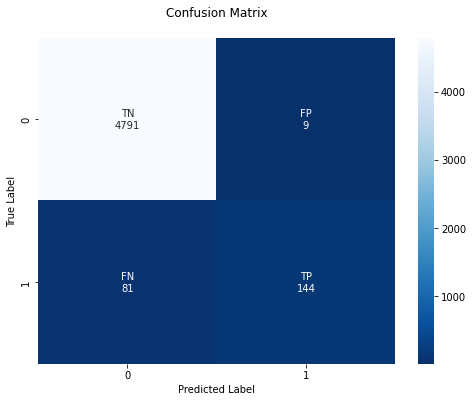

In [ ]:
print('F1-Score Valid =', round(f1_score(y_valid, y_valid_hat_stacking), 5), '\n')
class_names = [0, 1]
visualize_confusion_matrix(y_valid, y_valid_hat_stacking, class_names)

In [ ]:
print('Accuracy Score Valid =', round(accuracy_score(y_valid, y_valid_hat_stacking), 5))

Accuracy Score Valid = 0.98209


**Tunning threshold**

**(1) My best results in the Company Bankruptcy Prediction competition**

In [ ]:
threshold = round(f1_score(y_valid, y_valid_hat_stacking) / 2, 5)
print('Choose threshold =', threshold, '(1/2 F1-score before tunning).') 

Choose threshold = 0.38095 (1/2 F1-score before tunning).


In [ ]:
y_train_hat_stacking_proba = completed_pl_stacking.predict_proba(X_train)
y_valid_hat_stacking_proba = completed_pl_stacking.predict_proba(X_valid)

y_train_hat_stacking_new = (y_train_hat_stacking_proba[:, 1] >= threshold).astype(int)
y_valid_hat_stacking_new = (y_valid_hat_stacking_proba[:, 1] >= threshold).astype(int)

print('TRAINING DATA\n')
print(classification_report(y_train, y_train_hat_stacking_new))
print('\n\nVALIDATION DATA\n')
print(classification_report(y_valid, y_valid_hat_stacking_new))

TRAINING DATA

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19195
           1       1.00      0.97      0.98       901

    accuracy                           1.00     20096
   macro avg       1.00      0.99      0.99     20096
weighted avg       1.00      1.00      1.00     20096



VALIDATION DATA

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4800
           1       0.92      0.67      0.77       225

    accuracy                           0.98      5025
   macro avg       0.95      0.83      0.88      5025
weighted avg       0.98      0.98      0.98      5025



New F1-Score Valid = 0.7732 



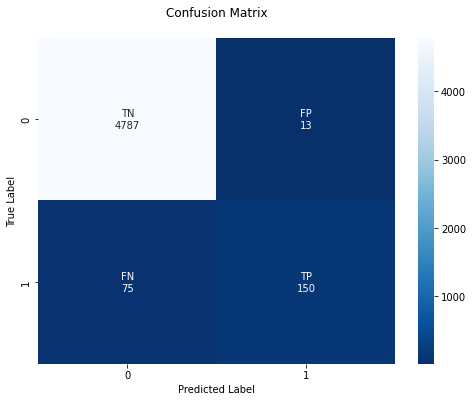

In [ ]:
print('New F1-Score Valid =', round(f1_score(y_valid, y_valid_hat_stacking_new), 5), '\n')
class_names = [0, 1]
visualize_confusion_matrix(y_valid, y_valid_hat_stacking_new, class_names)

In [ ]:
print('New Accuracy Score Valid =', round(accuracy_score(y_valid, y_valid_hat_stacking_new), 5))

New Accuracy Score Valid = 0.98249


**Results according to forecasting_period**

In [ ]:
forecasting_period_score_df = score_forecasting_period(
    X_forecasting_period=X_valid_forecasting_period, 
    y=y_valid, 
    y_hat=y_valid_hat_stacking_new, 
    list_forecasting_period=list_forecasting_period
)

forecasting_period_score_df

,forecasting_period,f1_valid,recall_valid,precision_valid,accuracy_valid
0,1,0.835821,0.777778,0.903226,0.988518
1,2,0.734694,0.610169,0.923077,0.980966
2,3,0.725490,0.596774,0.925000,0.980583
3,4,0.809917,0.720588,0.924528,0.981732


In [ ]:
# Predicted results on validation data
submission_demo_file_path = '/content/drive/MyDrive/Projects/Company Bankruptcy Prediction/submission/submission_demo.csv'

stacking_submit_df = display_and_export_submission(
    model=completed_pl_stacking,
    data=X_valid,
    list_id=X_valid['forecasting_period'],
    file_path=submission_demo_file_path,
    have_proba=True,
    threshold=threshold, 
    description='Valid data statistics'
)

Valid data statistics


,Count,Percentage
0,4862,96.756219
1,163,3.243781


In [ ]:
# Predicted results on test data
submission_1_file_path = '/content/drive/MyDrive/Projects/Company Bankruptcy Prediction/submission/submission_StdNe9_Stack_noSMOTE_threshold_depth6_19062022.csv'

stacking_submit_df_1 = display_and_export_submission(
    model=completed_pl_stacking,
    data=X_test,
    list_id=test_df['id'],
    file_path=submission_1_file_path,
    have_proba=True,
    threshold=threshold
)

Test data statistics



,Count,Percentage
0,11966,96.702764
1,408,3.297236


**Result on Kaggle**

| Public Score | 
| ----- -------| 
| 0.97833      | 

* **(2) This is method used to optimize F1-Score Valid**

In [ ]:
optimal_threshold = tunning_threshold(
    y_valid, y_valid_hat_stacking_proba[:, 1], 
    thresholds = np.arange(0, 1, 0.001)
)

Threshold = 0.089, F1-Score = 0.78220


In [ ]:
y_train_hat_stacking_new_2 = (y_train_hat_stacking_proba[:, 1] >= optimal_threshold).astype(int)
y_valid_hat_stacking_new_2 = (y_valid_hat_stacking_proba[:, 1] >= optimal_threshold).astype(int)

print('TRAINING DATA\n')
print(classification_report(y_train, y_train_hat_stacking_new_2))
print('\n\nVALIDATION DATA\n')
print(classification_report(y_valid, y_valid_hat_stacking_new_2))

TRAINING DATA

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19195
           1       0.96      0.99      0.98       901

    accuracy                           1.00     20096
   macro avg       0.98      1.00      0.99     20096
weighted avg       1.00      1.00      1.00     20096



VALIDATION DATA

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4800
           1       0.83      0.74      0.78       225

    accuracy                           0.98      5025
   macro avg       0.91      0.87      0.89      5025
weighted avg       0.98      0.98      0.98      5025



Optimal F1-score Valid = 0.7822 



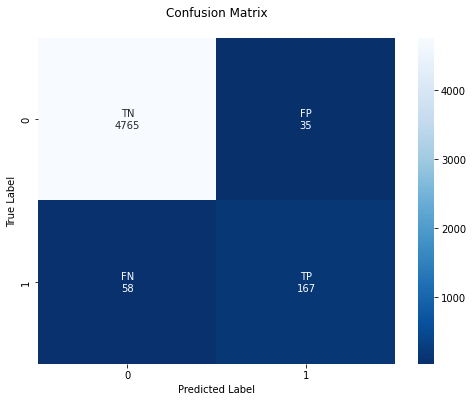

In [ ]:
print('Optimal F1-score Valid =', round(f1_score(y_valid, y_valid_hat_stacking_new_2), 5), '\n')
class_names = [0, 1]
visualize_confusion_matrix(y_valid, y_valid_hat_stacking_new_2, class_names)

In [ ]:
print('New Accuracy Score Valid =', round(accuracy_score(y_valid, y_valid_hat_stacking_new_2), 5))

New Accuracy Score Valid = 0.98149


**Results according to forecasting_period**

In [ ]:
forecasting_period_score_df_2 = score_forecasting_period(
    X_forecasting_period=X_valid_forecasting_period, 
    y=y_valid, 
    y_hat=y_valid_hat_stacking_new_2, 
    list_forecasting_period=list_forecasting_period
)

forecasting_period_score_df_2

,forecasting_period,f1_valid,recall_valid,precision_valid,accuracy_valid
0,1,0.833333,0.833333,0.833333,0.987474
1,2,0.728972,0.661017,0.812500,0.978770
2,3,0.761062,0.693548,0.843137,0.981276
3,4,0.814815,0.808824,0.820896,0.980143


In [ ]:
# Predicted results on validation data
submission_demo_file_path = '/content/drive/MyDrive/Projects/Company Bankruptcy Prediction/submission/submission_demo.csv'

stacking_submit_df = display_and_export_submission(
    model=completed_pl_stacking,
    data=X_valid,
    list_id=X_valid['forecasting_period'],
    file_path=submission_demo_file_path,
    have_proba=True,
    threshold=optimal_threshold, 
    description='Valid data statistics'
)

Valid data statistics


,Count,Percentage
0,4823,95.9801
1,202,4.0199


In [ ]:
# Predicted results on test data
submission_2_file_path = '/content/drive/MyDrive/Projects/Company Bankruptcy Prediction/submission/submission_stacking_no_smote_optimal_threshold.csv'

stacking_submit_df_2 = display_and_export_submission(
    model=completed_pl_stacking,
    data=X_test,
    list_id=test_df['id'],
    file_path=submission_2_file_path,
    have_proba=True,
    threshold=optimal_threshold
)

Test data statistics



,Count,Percentage
0,11835,95.644092
1,539,4.355908


**Result on Kaggle** 

| Public Score | 
| ----- -------| 
| 0.97413      | 

##### **b. Using SMOTE**


In [ ]:
stacking_score_df = run_model_with_smote_ratios(
    X_train, y_train,
    X_valid, y_valid,
    model=stacking_model,
    model_name='Stacking',
    list_smote_ratios=list_smote_ratios
)

stacking_score_df

,model,f1_train,f1_valid,recall_train,recall_valid,precision_train,precision_valid,accuracy_train,accuracy_valid
0,Stacking - 0.1,0.996663,0.764103,0.994451,0.662222,0.998885,0.903030,0.999701,0.981692
1,Stacking - 0.8,0.999445,0.754522,0.998890,0.648889,1.000000,0.901235,0.999950,0.981095
2,Stacking - 0.9,1.000000,0.751295,1.000000,0.644444,1.000000,0.900621,1.000000,0.980896
3,Stacking - 0.3,0.996126,0.746341,0.998890,0.680000,0.993377,0.827027,0.999652,0.979303
4,Stacking - 0.4,0.999445,0.744063,0.998890,0.626667,1.000000,0.915584,0.999950,0.980697
5,Stacking - 0.6,0.999445,0.741514,0.998890,0.631111,1.000000,0.898734,0.999950,0.980299
6,Stacking - 0.2,0.998332,0.740554,0.996670,0.653333,1.000000,0.854651,0.999851,0.979502
7,Stacking - 0.7,1.000000,0.740360,1.000000,0.640000,1.000000,0.878049,1.000000,0.979900
8,Stacking - 1.0,0.998891,0.737113,1.000000,0.635556,0.997785,0.877301,0.999900,0.979701
9,Stacking - 0.5,0.998334,0.734908,0.997780,0.622222,0.998889,0.897436,0.999851,0.979900


**Result:** Using SMOTE to generate samples with ratio **`class=1`/`class=0` = 0.1** helps achieve the best F1-Score Valid among Stacking models used SMOTE.

In [ ]:
completed_pl_stacking_smote = Imbpipeline(
    steps=[ 
        ('preprocessor', preprocessor), 
        ('smote', SMOTE(sampling_strategy=0.1, random_state=0)),
        ('classifier', stacking_model)
    ]
)
completed_pl_stacking_smote.fit(X_train, y_train)
y_train_hat_stacking_smote = completed_pl_stacking_smote.predict(X_train)
y_valid_hat_stacking_smote = completed_pl_stacking_smote.predict(X_valid)

print('TRAINING DATA\n')
print(classification_report(y_train, y_train_hat_stacking_smote))
print('\n\nVALIDATION DATA\n')
print(classification_report(y_valid, y_valid_hat_stacking_smote))

TRAINING DATA

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19195
           1       1.00      0.99      1.00       901

    accuracy                           1.00     20096
   macro avg       1.00      1.00      1.00     20096
weighted avg       1.00      1.00      1.00     20096



VALIDATION DATA

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4800
           1       0.90      0.66      0.76       225

    accuracy                           0.98      5025
   macro avg       0.94      0.83      0.88      5025
weighted avg       0.98      0.98      0.98      5025



F1-Score Valid = 0.7641 



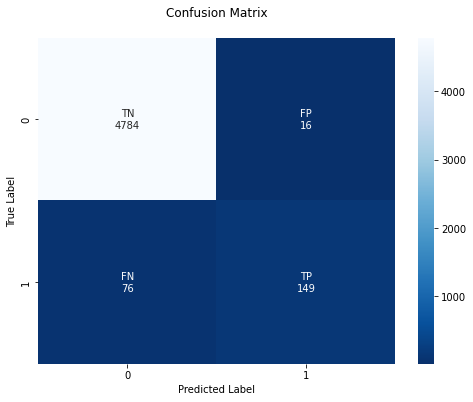

In [ ]:
print('F1-Score Valid =', round(f1_score(y_valid, y_valid_hat_stacking_smote), 5), '\n')
class_names = [0, 1]
visualize_confusion_matrix(y_valid, y_valid_hat_stacking_smote, class_names)

In [ ]:
print('Accuracy Score Valid =', round(accuracy_score(y_valid, y_valid_hat_stacking_smote), 5))

Accuracy Score Valid = 0.98169


**Results according to forecasting_period**

In [ ]:
forecasting_period_score_df_3 = score_forecasting_period(
    X_forecasting_period=X_valid_forecasting_period, 
    y=y_valid, 
    y_hat=y_valid_hat_stacking_smote, 
    list_forecasting_period=list_forecasting_period
)

forecasting_period_score_df_3

,forecasting_period,f1_valid,recall_valid,precision_valid,accuracy_valid
0,1,0.818182,0.750000,0.900000,0.987474
1,2,0.740000,0.627119,0.902439,0.980966
2,3,0.693069,0.564516,0.897436,0.978502
3,4,0.813008,0.735294,0.909091,0.981732


In [ ]:
# Predicted results on validation data
submission_demo_file_path = '/content/drive/MyDrive/Projects/Company Bankruptcy Prediction/submission/submission_demo.csv'

stacking_submit_df = display_and_export_submission(
    model=completed_pl_stacking_smote,
    data=X_valid,
    list_id=X_valid['forecasting_period'],
    file_path=submission_demo_file_path,
    have_proba=False,
    description='Valid data statistics'
)

Valid data statistics


,Count,Percentage
0,4860,96.716418
1,165,3.283582


In [ ]:
# Predicted results on test data
submission_3_file_path = '/content/drive/MyDrive/Projects/Company Bankruptcy Prediction/submission/submission_StdNe9_Stack0.1_depth6_19062022.csv'

stacking_submit_df_3 = display_and_export_submission(
    model=completed_pl_stacking_smote,
    data=X_test,
    list_id=test_df['id'],
    file_path=submission_3_file_path,
    have_proba=False
)

Test data statistics



,Count,Percentage
0,11926,96.379505
1,448,3.620495


**Result on Kaggle**

| Public Score |
| ----- -------| 
| 0.98060      |

**Tunning threshold**

In [ ]:
y_train_hat_stacking_smote_proba = completed_pl_stacking_smote.predict_proba(X_train)
y_valid_hat_stacking_smote_proba = completed_pl_stacking_smote.predict_proba(X_valid)

In [ ]:
optimal_threshold_smote = tunning_threshold(
    y_valid, y_valid_hat_stacking_smote_proba[:,1], 
    thresholds = np.arange(0, 1, 0.001)
)

Threshold = 0.499, F1-Score = 0.76410


**Comment:** After tunning, the best threshold is also current threshold = 0.5, F1-Score Valid = 0.7641.

**Result:** This result is not as good as the result of Stacking model without using SMOTE + after tunning threshold.

## **IV. Conclusion**

**Summary of the best results**

|Index| Model        | F1-Score Valid |Accuracy Score Valid | Public Score |Selected Submissions | Private Score |
|---| -------------| ------------- |------------- | ----- -------| ------------- |---------|
|1  |Stacking + Without using SMOTE + Threshold=0.089|0.7822|0.98149|0.97413|✕|0.97952|
|2  |Stacking + Without using SMOTE + Threshold=0.38095|0.7732|0.98249|0.97833|✓|0.98297|
|3  |Stacking + SMOTE 0.1|0.7641|0.98169|0.98060|✓|0.98135|

**Comment**

* <p align="justify">After using many methods to improve F1-Score Valid, the best result was 0.7822 for model Stacking + Without using SMOTE + Threshold=0.089.

* <p align="justify">Evaluating on the test set - Kaggle, model Stacking + Without using SMOTE + Threshold=0.089 gave not as good results as other 2 models.

* <p align="justify">The score difference between the validation set and the test set shows that it is likely that the evaluation of the competition on Kaggle is being set to Accuracy because the Accuracy Score on the validation set also gives similar results to the results on Kaggle.</p>

* <p align="justify">2 selected submissions for the competition were predictions of 2 models Stacking + Without using SMOTE  + Threshold=0.38095 and Stacking + SMOTE 0.1.</p>

* <p align="justify">Evaluating on the test set - Kaggle, model Stacking + Without using SMOTE + Threshold=0.38095 gave the best Private Score.


**Conclusion:** My best solution for the competition is model **Stacking + Without using SMOTE + Threshold=0.38095** with **Private Score = 0.98297**.

# **D. Reference**

1. Xử lý dữ liệu bị khuyết (missing data) , *https<span>://</span>courses.funix.edu.vn/courses/course-v1:FUNiX+MLP302x_1.2-A_VN+2021_T8/info*
2. Oversampling (lấy mẫu thừa) , *https<span>://</span>courses.funix.edu.vn/courses/course-v1:FUNiX+MLP303x_1.2-A_VN+2021_T9/info*
3. Xử lý các giá trị ngoại lệ, *https<span>://</span>machinelearningcoban.com/tabml_book/ch_data_processing/process_outliers.html*
4. Sklearn Pipeline, *https<span></span>://phamdinhkhanh.github.io/deepai-book/ch_appendix/index_pipeline.html*
5. What is LightGBM, How to implement it? How to fine tune the parameters?, *https<span></span>://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc*
6. Grid Search for Hyperparameter Tuning, *https<span></span>://towardsdatascience.com/grid-search-for-hyperparameter-tuning-9f63945e8fec#:~:text=GridSearchCV%20is%20a%20library%20function,parameters%20from%20the%20listed%20hyperparameters.*
7. Parameters Tuning, *https<span></span>://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html*
8. Parameter tuning, *https<span></span>://catboost.ai/en/docs/concepts/parameter-tuning*
9. On Optimal Threshold for Maximizing F1 Score,  *https<span></span>://hippocampus-garden.com/f1*